# Cyber IDS – Intrusion Detection on CSE-CIC-IDS2018 (Binary Attack vs Benign)

This notebook implements the Cyber IDS project, building a binary intrusion detector (Attack vs Benign) on the CSE-CIC-IDS2018 dataset using classical machine learning (Logistic Regression, Random Forest, XGBoost) and probability calibration.

The primary goals are:

- Optimize for PR-AUC and Recall at low False Positive Rate (FPR), especially at 1% FPR.
- Provide a reproducible experimentation with fixed seeds and clear data splits.
- Produce code that is modular and ready to be moved into Django Ninja API endpoints:
  - `/ml/train`
  - `/ml/predict`
  - `/ml/metrics`

This notebook is intended as the demo for the Cyber IDS system design, but it can also be used within a Django Ninja project, as detailed in Sections 1 through 6.

# Using this notebook inside a Django Ninja project (PyCharm workflow)

This notebook is not only a research / demo artifact; it also acts as the **reference implementation** for a Django + Django Ninja API that exposes the Cyber IDS model via endpoints such as:

- `POST /ml/train`
- `POST /ml/predict`
- `GET  /ml/metrics`

To keep the main narrative focused on ML, the **full Django Ninja integration guide** (including `services.py`, Pydantic schemas, and the `/ml/predict` endpoint) has been moved to the **Appendix**:

- See **Appendix – Django Ninja Integration: Services Module** for:
  - How to load the latest model, feature list, metadata, and sanitizer artifacts.
  - How to implement a small `services.py` layer that mirrors the notebook logic.
- See **Appendix – Django Ninja Integration: Pydantic Schemas & `/ml/predict` Endpoint** for:
  - How to define request / response models with Pydantic.
  - How to expose the calibrated Cyber IDS model through a Django Ninja router.

In practice, the workflow is:

1. Run this notebook end‑to‑end and export artifacts (model, features, metadata, sanitizer) into `artifacts/`.
2. Copy the `artifacts/` folder into your Django project (for example next to `manage.py` or inside your `cyber_ids` app).
3. Implement the code shown in the **Appendix** inside your Django app:
   - `cyber_ids/services.py` – model loading and sanitization helpers.
   - `cyber_ids/api.py` – Ninja router and `/ml/predict` endpoint.
4. Include the Ninja router in your main `urls.py` (standard Django Ninja setup).

> **Reminder:** The notebook and the Django project must agree on:
> - The feature list used for training (`cyber_ids_features_*.json`).
> - The sanitization mapping used to handle NaN/inf values.
> - The model version you want to serve in production.

For concrete code snippets, scroll down to the **Django Ninja Integration** appendices at the end of the notebook.


# Notebook Specification

In [11]:
# ======================================================================
# Cell 1
# Steps
#   1. Install required Python packages with %pip magic.
# ======================================================================

# 1. Install required Python packages with %pip magic.
%pip install scikit-learn
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [117]:
# ======================================================================
# Cell 2 – Setup
# Purpose
#   - Import core Python, scientific, plotting, and ML libraries used across the notebook.
#   - Configure global settings such as multiprocessing, warning filters, and plotting defaults.
#   - Print key library versions to make runs easier to reproduce and debug.
# Notes
#   - Tree-based models (RandomForest, XGBoost) do not require feature scaling.
#   - We fix random seeds for Python, NumPy, and random to ease debugging.
# Steps
#   1. Import standard library, scientific, and plotting packages.
#   2. Import scikit-learn and XGBoost utilities.
#   3. Set global RANDOM_STATE and seeds for reproducibility.
#   4. Configure Matplotlib defaults for consistent visual style.
#   5. Optionally adjust any runtime knobs (e.g., FAST_MODE flags).
# ======================================================================

"""
Environment setup: imports, random seeds, and plotting configuration.

"""
# Standard libraries
#   1. Import standard libraries, scientific, and plotting packages.
import os
import gc
import random
import json
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional, Optional
import joblib

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#   2. Import scikit-learn and XGBoost utilities.
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    brier_score_loss,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
#   2. Import scikit-learn and XGBoost utilities.
from xgboost import XGBClassifier

In [118]:
# ======================================================================
# Cell 3 – Random seed & plotting configuration
# Purpose
#   - Fix the global random seed for Python, NumPy, and hashing to make experiments reproducible.
#   - Configure seaborn/Matplotlib defaults so all plots share a consistent look and feel.
#   - Print a short confirmation message so we know the environment is ready.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Declare a single RANDOM_STATE constant to be reused across the notebook.
#   2. Seed Python’s built-in random module with RANDOM_STATE.
#   3. Seed NumPy’s random number generator with RANDOM_STATE.
#   4. Set PYTHONHASHSEED so hash-based operations behave deterministically.
#   5. Apply a seaborn style for a clean “whitegrid” background on all plots.
#   6. Set the default Matplotlib figure size for all figures.
#   7. Set the default font size for axis titles.
#   8. Set the default font size for axis labels.
#   9. Set the default font size for legends.
#   10. Set the global default font size for all text in Matplotlib figures.
#   11. Print a confirmation message including the RANDOM_STATE value.
# ======================================================================

# -------------------------------------------------------------------------
# Global random seed configuration
# -------------------------------------------------------------------------

# 1. Declare a single RANDOM_STATE constant to be reused across the notebook.
RANDOM_STATE: int = 42

# 2. Seed Python’s built-in random module with RANDOM_STATE.
random.seed(RANDOM_STATE)

# 3. Seed NumPy’s random number generator with RANDOM_STATE.
np.random.seed(RANDOM_STATE)

# 4. Set PYTHONHASHSEED so hash-based operations behave deterministically.
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)

# -------------------------------------------------------------------------
# Plotting configuration
# -------------------------------------------------------------------------

# 5. Apply a seaborn style for a clean “whitegrid” background on all plots.
sns.set(style="whitegrid")

# 6. Set the default Matplotlib figure size for all figures.
plt.rcParams["figure.figsize"] = (8, 5)

# 7. Set the default font size for axis titles.
plt.rcParams["axes.titlesize"] = 14

# 8. Set the default font size for axis labels.
plt.rcParams["axes.labelsize"] = 12

# 9. Set the default font size for legends.
plt.rcParams["legend.fontsize"] = 10

# 10. Set the global default font size for all text in Matplotlib figures.
plt.rcParams["font.size"] = 11

# 11. Print a confirmation message including the RANDOM_STATE value.
print("Environment ready. Random seed set to", RANDOM_STATE)


Environment ready. Random seed set to 42


## Environment Setup & Configuration

This section prepares the runtime environment for the Cyber IDS experiments:
- imports the core scientific‑Python stack and scikit‑learn helpers;
- fixes the global random seed so results are reproducible across runs;
- configures seaborn / Matplotlib defaults so plots share a consistent style;
- declares where the CSE‑CIC‑IDS2018 daily CSV/Parquet files live on disk;
- defines global constants such as the target column, benign labels and CSV loading options (chunk size, row caps).


In [119]:
# ======================================================================
# Cell 5 – Dataset paths and configuration
# Purpose
#   - Declare where the CSE-CIC-IDS2018 daily files live on disk (DATA_ROOT).
#   - Specify which days or scenarios belong to the training set and which belong to the test set.
#   - Define common configuration constants such as TARGET_COLUMN and BENIGN_LABELS.
#   - Configure memory-related limits (MAX_ROWS_PER_SPLIT, chunked CSV reading) to avoid OOM errors.
#   - Print the resolved configuration so it is easy to debug and adapt on another machine.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Provide a short configuration docstring explaining how to adapt this cell.
#   2. Define DATA_ROOT pointing to the local CSE-CIC-IDS2018 folder.
#   3. Declare the TRAIN_DAYS list (days used for training).
#   4. Declare the TEST_DAYS list (days used for evaluation).
#   5. Set FILE_EXTENSION (CSV vs Parquet) for the daily files.
#   6. Set TARGET_COLUMN name for the label column.
#   7. Define which label values are treated as benign (BENIGN_LABELS).
#   8. Explain and set MAX_ROWS_PER_SPLIT to cap rows per split for memory safety.
#   9. Enable or disable chunked CSV loading via USE_CHUNKED_LOADING.
#   10. Set CSV_CHUNKSIZE used when chunked loading is active.
#   11. Print a “Configuration loaded” banner.
#   12. Print the resolved DATA_ROOT path.
#   13. Print the TRAIN_DAYS list.
#   14. Print the TEST_DAYS list.
#   15. Print the FILE_EXTENSION value.
#   16. Print the TARGET_COLUMN value.
#   17. Print the BENIGN_LABELS list.
#   18. Print the MAX_ROWS_PER_SPLIT value.
# ======================================================================

# 1. Provide a short configuration docstring explaining how to adapt this cell.
"""
Configuration cell.

Update the paths and day names to match your local copy of CSE-CIC-IDS2018.
All other code below should work with minimal changes, as long as the dataset
is in the expected "one file per day/scenario" format.
"""

# Root folder where the CSE-CIC-IDS2018 CSV/Parquet files live.
# 2. Define DATA_ROOT pointing to the local CSE-CIC-IDS2018 folder.
DATA_ROOT: Path = Path("CSE-CIC-IDS2018")  # <-- UPDATE THIS TO YOUR LOCAL PATH

# Example day identifiers (adjust to your actual filenames)
# 3. Declare the TRAIN_DAYS list (days used for training).
TRAIN_DAYS: List[str] = [
    "Friday-02-03-2018",
    "Wednesday-21-02-2018",
    "Thursday-22-02-2018",
]

# 4. Declare the TEST_DAYS list (days used for evaluation).
TEST_DAYS: List[str] = [
    "Wednesday-14-02-2018",
]

# 5. Set FILE_EXTENSION (CSV vs Parquet) for the daily files.
FILE_EXTENSION: str = "csv"  # or "parquet"

# 6. Set TARGET_COLUMN name for the label column.
TARGET_COLUMN: str = "Label"

# 7. Define which label values are treated as benign (BENIGN_LABELS).
BENIGN_LABELS: List[str] = ["Benign"]

# -------------------------------------------------------------------------
# Memory-related configuration
# -------------------------------------------------------------------------

# 8. Explain and set MAX_ROWS_PER_SPLIT to cap rows per split for memory safety.
#    This caps the number of rows loaded for *each* of train/test so that
#    building feature matrices does not exhaust RAM on modest machines.
#    Set to None if you have plenty of memory and want to load all rows.
MAX_ROWS_PER_SPLIT: Optional[int] = 500_000  # safer default; adjust as needed

# 9. Enable or disable chunked CSV loading via USE_CHUNKED_LOADING.
#    Chunked loading avoids ParserError / OOM on very large CSV files.
USE_CHUNKED_LOADING: bool = True

# 10. Set CSV_CHUNKSIZE used when chunked loading is active.
CSV_CHUNKSIZE: int = 20_000  # smaller chunks → lower peak memory, longer load time

# 11. Print a “Configuration loaded” banner.
print("Configuration loaded.")

# 12. Print the resolved DATA_ROOT path.
print("  DATA_ROOT:", DATA_ROOT)

# 13. Print the TRAIN_DAYS list.
print("  TRAIN_DAYS:", TRAIN_DAYS)

# 14. Print the TEST_DAYS list.
print("  TEST_DAYS:", TEST_DAYS)

# 15. Print the FILE_EXTENSION value.
print("  FILE_EXTENSION:", FILE_EXTENSION)

# 16. Print the TARGET_COLUMN value.
print("  TARGET_COLUMN:", TARGET_COLUMN)

# 17. Print the BENIGN_LABELS list.
print("  BENIGN_LABELS:", BENIGN_LABELS)

# 18. Print the MAX_ROWS_PER_SPLIT value.
print("  MAX_ROWS_PER_SPLIT:", MAX_ROWS_PER_SPLIT)


Configuration loaded.
  DATA_ROOT: CSE-CIC-IDS2018
  TRAIN_DAYS: ['Friday-02-03-2018', 'Wednesday-21-02-2018', 'Thursday-22-02-2018']
  TEST_DAYS: ['Wednesday-14-02-2018']
  FILE_EXTENSION: csv
  TARGET_COLUMN: Label
  BENIGN_LABELS: ['Benign']
  MAX_ROWS_PER_SPLIT: 500000


## Modular Data Loading Utilities

This section implements modular helpers to read the CSE‑CIC‑IDS2018 daily flow files from disk into pandas DataFrames in a memory‑aware way:
- locates all CSV/Parquet files for a list of day identifiers under `DATA_ROOT`;
- loads individual files with robust CSV parsing, optional chunked reading and row caps to avoid out‑of‑memory errors;
- concatenates per‑day files into single train/test DataFrames while respecting maximum‑row limits;
- provides a `load_raw_dataset(...)` convenience wrapper that builds the raw train and test tables from the configured day lists.


In [120]:
# ======================================================================
# Cell 7 – Cyber IDS code
# Purpose
#   - Provide a reusable helper function for listing CSE-CIC-IDS2018 daily files on disk.
#   - Support reading multiple CSV/Parquet files by discovering them via day-based filename patterns.
#   - Centralize file discovery so later cells can load train/test data in a consistent way.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define the `list_data_files` helper function and its parameters.
#   2. Validate that the requested file extension is supported (csv/parquet).
#   3. Initialize an accumulator list for all discovered file paths.
#   4. For each requested day, build a glob pattern and search recursively under `data_root`.
#   5. Log a warning if no files are found, or an info message if files are found.
#   6. Append all paths for that day to the global accumulator.
#   7. Return the sorted list of all discovered file paths.
# ======================================================================

# 1. Define the `list_data_files` helper function and its parameters.
def list_data_files(
    data_root: Path,
    days: List[str],
    extension: str = "csv",
) -> List[Path]:
    """
    Discover data files for the given list of day identifiers.

    We look for files matching the glob pattern: `*{day}*.{extension}` under
    `data_root`, recursively. This is flexible enough for filenames like:

    - Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
    - merge_Friday-23-02-2018_attack.csv
    """

    # 2. Validate that the requested file extension is supported (csv/parquet).
    if extension not in {"csv", "parquet"}:
        raise ValueError(f"Unsupported extension: {extension!r}")

    # 3. Initialize an accumulator list for all discovered file paths.
    all_paths: List[Path] = []

    # 4. For each requested day, build a glob pattern and search recursively under `data_root`.
    for day in days:
        pattern = f"*{day}*.{extension}"
        day_paths = sorted(data_root.rglob(pattern))

        # 5. Log a warning if no files are found, or an info message if files are found.
        if not day_paths:
            print(f"[WARN] No files found for day pattern {day!r} with pattern {pattern!r}")
        else:
            print(f"[INFO] Found {len(day_paths)} file(s) for day {day!r}")

        # 6. Append all paths for that day to the global accumulator.
        all_paths.extend(day_paths)

    # 7. Return the sorted list of all discovered file paths.
    return sorted(all_paths)


In [121]:
# ======================================================================
# Cell 8 – Cyber IDS code
# Purpose
#   - Implement a low-level helper to read a single CSV/Parquet daily file with optional chunking.
#   - Handle malformed lines and very large files in a memory-conscious, defensive way.
#   - Return a clean DataFrame for each individual file to be consumed by higher-level loaders.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define the `_read_single_file` helper function and its parameters.
#   2. If the extension is CSV, configure chunked reading with the Python engine.
#   3. Initialize the chunk accumulator and compute an effective chunk size based on `max_rows`.
#   4. Stream CSV chunks, accumulate rows, and stop once the `max_rows` limit is reached.
#   5. Handle the empty or all-bad-lines case by returning an empty DataFrame.
#   6. Concatenate all accumulated chunks into a single DataFrame for CSV input.
#   7. If the extension is Parquet, read the file once and optionally cap the number of rows.
#   8. Raise a clear error if the extension is neither CSV nor Parquet.
# ======================================================================

# 1. Define the `_read_single_file` helper function and its parameters.
def _read_single_file(
    path: Path,
    extension: str = "csv",
    use_chunks: bool = False,
    chunksize: int = 20_000,
    max_rows: Optional[int] = None,
) -> pd.DataFrame:
    """
    VERY defensive loader for a single CSV or Parquet file.

    For CSV:
    - Always uses the *python* engine instead of the C engine.
      This is slower but much more forgiving and less likely to hit
      `C error: out of memory` during tokenization.
    - Always uses chunked reading, with relatively small chunks.
    - Hard-stops once `max_rows` is reached.

    For Parquet:
    - Just reads with `read_parquet` and applies the same `max_rows` cap.
    """

    # 2. If the extension is CSV, configure chunked reading with the Python engine.
    if extension == "csv":
        # 3. Initialize the chunk accumulator and compute an effective chunk size based on `max_rows`.
        chunks: List[pd.DataFrame] = []
        loaded_rows = 0
        effective_chunksize = chunksize
        if max_rows is not None:
            # If we only need at most `max_rows`, there is no benefit in having larger chunks.
            effective_chunksize = min(chunksize, max_rows)

        # 4. Stream CSV chunks, accumulate rows, and stop once the `max_rows` limit is reached.
        for chunk in pd.read_csv(
            path,
            engine="python",        # more tolerant than the C engine
            chunksize=effective_chunksize,
            on_bad_lines="skip",    # skip badly-formed lines instead of failing
        ):
            chunks.append(chunk)
            loaded_rows += len(chunk)

            if max_rows is not None and loaded_rows >= max_rows:
                # If we overshot the desired maximum, trim the last chunk.
                excess = loaded_rows - max_rows
                if excess > 0:
                    chunks[-1] = chunks[-1].iloc[:-excess]
                    loaded_rows -= excess
                break

        # 5. Handle the empty or all-bad-lines case by returning an empty DataFrame.
        if not chunks:
            # Empty file case or all-bad-lines: return an empty DataFrame with no columns.
            return pd.DataFrame()

        # 6. Concatenate all accumulated chunks into a single DataFrame for CSV input.
        df = pd.concat(chunks, ignore_index=True)

    # 7. If the extension is Parquet, read the file once and optionally cap the number of rows.
    elif extension == "parquet":
        df = pd.read_parquet(path)
        if max_rows is not None:
            df = df.iloc[:max_rows].copy()

    # 8. Raise a clear error if the extension is neither CSV nor Parquet.
    else:
        raise ValueError(f"Unsupported extension: {extension!r}")

    return df


In [122]:
# ======================================================================
# Cell 9 – Cyber IDS code
# Purpose
#   - Implement a helper that loads multiple daily CSE-CIC-IDS2018 files and concatenates them.
#   - Respect a global `max_rows` cap so we do not load more rows than desired into memory.
#   - Use the low-level `_read_single_file` routine to handle CSV/Parquet and chunking safely.
#   - Return a single combined DataFrame that later cells will treat as raw train/test data.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define the `load_day_files` helper function and its parameters.
#   2. Initialize an empty list to accumulate per-file DataFrames and a row counter.
#   3. For each file path, compute how many rows we are still allowed to load (based on `max_rows`).
#   4. If no rows remain under the `max_rows` cap, stop reading further files.
#   5. Call `_read_single_file` to load the current file with the requested options.
#   6. Append the loaded DataFrame to the accumulator and update the total row count.
#   7. Print a progress message showing how many rows were loaded from the current file and in total.
#   8. If the global `max_rows` limit has been reached, stop processing additional files.
#   9. If no frames were loaded at all, raise a RuntimeError to signal a configuration/path problem.
#   10. Concatenate all per-file DataFrames into a single combined DataFrame.
#   11. Print the final combined shape and return the result.
# ======================================================================

# 1. Define the `load_day_files` helper function and its parameters.
def load_day_files(
    file_paths: List[Path],
    extension: str = "csv",
    use_chunks: bool = False,
    chunksize: int = 500_000,
    max_rows: Optional[int] = None,
) -> pd.DataFrame:
    """Load and concatenate multiple day files into a single DataFrame."""

    # 2. Initialize an empty list to accumulate per-file DataFrames and a row counter.
    frames: List[pd.DataFrame] = []
    loaded_rows_total = 0

    # 3. For each file path, compute how many rows we are still allowed to load (based on `max_rows`).
    for path in file_paths:
        remaining_rows = None
        if max_rows is not None:
            remaining_rows = max_rows - loaded_rows_total

            # 4. If no rows remain under the `max_rows` cap, stop reading further files.
            if remaining_rows <= 0:
                break

        # 5. Call `_read_single_file` to load the current file with the requested options.
        df_file = _read_single_file(
            path=path,
            extension=extension,
            use_chunks=use_chunks,
            chunksize=chunksize,
            max_rows=remaining_rows,
        )

        # 6. Append the loaded DataFrame to the accumulator and update the total row count.
        frames.append(df_file)
        loaded_rows_total += len(df_file)

        # 7. Print a progress message showing how many rows were loaded from the current file and in total.
        print(
            f"[INFO] Loaded {len(df_file):,} rows from {path.name} "
            f"(total so far = {loaded_rows_total:,})"
        )

        # 8. If the global `max_rows` limit has been reached, stop processing additional files.
        if max_rows is not None and loaded_rows_total >= max_rows:
            break

    # 9. If no frames were loaded at all, raise a RuntimeError to signal a configuration/path problem.
    if not frames:
        raise RuntimeError("No data loaded. Check DATA_ROOT, day patterns, and extension.")

    # 10. Concatenate all per-file DataFrames into a single combined DataFrame.
    combined = pd.concat(frames, ignore_index=True)

    # 11. Print the final combined shape and return the result.
    print(f"[INFO] Combined DataFrame shape: {combined.shape}")
    return combined


In [123]:
# ======================================================================
# Cell 10 – Cyber IDS code
# Purpose
#   - Provide an end-to-end helper that loads raw TRAIN and TEST datasets based on day lists.
#   - Use `list_data_files` to discover which files belong to train and test splits.
#   - Use `load_day_files` to actually read and concatenate those files into DataFrames.
#   - Return two raw DataFrames (train_df, test_df) that will feed the preprocessing pipeline.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define the `load_raw_dataset` helper function and its parameters.
#   2. Print a header indicating that TRAIN data is being loaded.
#   3. Discover all TRAIN file paths using `list_data_files`.
#   4. Load and concatenate TRAIN files into a single `train_df` using `load_day_files`.
#   5. Print a header indicating that TEST data is being loaded.
#   6. Discover all TEST file paths using `list_data_files`.
#   7. Load and concatenate TEST files into a single `test_df` using `load_day_files`.
#   8. Return the pair `(train_df, test_df)` for downstream processing.
# ======================================================================

# 1. Define the `load_raw_dataset` helper function and its parameters.
def load_raw_dataset(
    train_days: List[str],
    test_days: List[str],
    data_root: Path,
    extension: str = "csv",
    use_chunks: bool = False,
    chunksize: int = 500_000,
    max_rows_per_split: Optional[int] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """End-to-end loader for raw train and test datasets (split by day)."""

    # 2. Print a header indicating that TRAIN data is being loaded.
    print("=== Loading TRAIN data ===")

    # 3. Discover all TRAIN file paths using `list_data_files`.
    train_files = list_data_files(
        data_root=data_root,
        days=train_days,
        extension=extension,
    )

    # 4. Load and concatenate TRAIN files into a single `train_df` using `load_day_files`.
    train_df = load_day_files(
        file_paths=train_files,
        extension=extension,
        use_chunks=use_chunks,
        chunksize=chunksize,
        max_rows=max_rows_per_split,
    )

    # 5. Print a header indicating that TEST data is being loaded.
    print("\n=== Loading TEST data ===")

    # 6. Discover all TEST file paths using `list_data_files`.
    test_files = list_data_files(
        data_root=data_root,
        days=test_days,
        extension=extension,
    )

    # 7. Load and concatenate TEST files into a single `test_df` using `load_day_files`.
    test_df = load_day_files(
        file_paths=test_files,
        extension=extension,
        use_chunks=use_chunks,
        chunksize=chunksize,
        max_rows=max_rows_per_split,
    )

    # 8. Return the pair `(train_df, test_df)` for downstream processing.
    return train_df, test_df

## Data Understanding & Exploratory Data Analysis (EDA)

This section looks at the raw dataset to understand label balance, feature types and basic data quality:
- summarizes the multiclass label distribution for train and test days;
- derives a binary Attack vs Benign target and inspects its class imbalance;
- reports missing‑value rates per feature to spot problematic columns;
- draws bar charts and density plots for a handful of numeric features, split by binary class, to build intuition about separability.


In [124]:
# ======================================================================
# Cell 12 – Cyber IDS code
# Purpose
#   - Use the previously defined configuration and loaders to build raw train/test DataFrames.
#   - Provide a quick sanity check on the number of rows/columns for train and test splits.
#   - Visually inspect the first few rows of the training data to confirm it looks as expected.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Call `load_raw_dataset` with the configured train/test day lists and file options.
#   2. Print the shape (rows, columns) of the training DataFrame.
#   3. Print the shape (rows, columns) of the test DataFrame.
#   4. Display the first few rows of the training DataFrame for a visual sanity check.
# ======================================================================

# 1. Call `load_raw_dataset` with the configured train/test day lists and file options.
train_df, test_df = load_raw_dataset(
    train_days=TRAIN_DAYS,
    test_days=TEST_DAYS,
    data_root=DATA_ROOT,
    extension=FILE_EXTENSION,
    use_chunks=USE_CHUNKED_LOADING,
    chunksize=CSV_CHUNKSIZE,
    max_rows_per_split=MAX_ROWS_PER_SPLIT,
)

# 2. Print the shape (rows, columns) of the training DataFrame.
print("\nTrain shape:", train_df.shape)

# 3. Print the shape (rows, columns) of the test DataFrame.
print("Test shape :", test_df.shape)

# 4. Display the first few rows of the training DataFrame for a visual sanity check.
train_df.head()


=== Loading TRAIN data ===
[INFO] Found 1 file(s) for day 'Friday-02-03-2018'
[INFO] Found 1 file(s) for day 'Wednesday-21-02-2018'
[INFO] Found 1 file(s) for day 'Thursday-22-02-2018'
[INFO] Loaded 500,000 rows from Friday-02-03-2018.csv (total so far = 500,000)
[INFO] Combined DataFrame shape: (500000, 80)

=== Loading TEST data ===
[INFO] Found 1 file(s) for day 'Wednesday-14-02-2018'
[INFO] Loaded 500,000 rows from Wednesday-14-02-2018.csv (total so far = 500,000)
[INFO] Combined DataFrame shape: (500000, 80)

Train shape: (500000, 80)
Test shape : (500000, 80)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [125]:
# ======================================================================
# Cell 13 – Cyber IDS code
# Purpose
#   - Define helper functions to summarize label distributions and create a binary Attack vs Benign target.
#   - Inspect the original multi-class label distribution in train and test splits.
#   - Derive binary labels (0=Benign, 1=Attack) and inspect their class balance.
#   - Compute and display the top missing-value fractions for training features to inform preprocessing.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `summarize_class_distribution` to compute normalized label proportions.
#   2. Define helper function `make_binary_labels_series` to map raw labels to 0=Benign, 1=Attack.
#   3. Compute the multi-class label distribution for the training split.
#   4. Compute the multi-class label distribution for the test split.
#   5. Print a header for the training multi-class label distribution.
#   6. Display the training multi-class distribution as a DataFrame.
#   7. Print a header for the test multi-class label distribution.
#   8. Display the test multi-class distribution as a DataFrame.
#   9. Create binary labels for the training split using `BENIGN_LABELS`.
#   10. Create binary labels for the test split using `BENIGN_LABELS`.
#   11. Compute the binary class distribution for the training split.
#   12. Compute the binary class distribution for the test split.
#   13. Print a header for the training binary label distribution.
#   14. Display the training binary distribution as a DataFrame.
#   15. Print a header for the test binary label distribution.
#   16. Display the test binary distribution as a DataFrame.
#   17. Compute the fraction of missing values per column in the training DataFrame.
#   18. Print a header for the top-20 most-missing training columns.
#   19. Display the top-20 most-missing training columns and their missing fractions.
# ======================================================================

# 1. Define helper function `summarize_class_distribution` to compute normalized label proportions.
def summarize_class_distribution(df: pd.DataFrame, label_col: str) -> pd.Series:
    """Compute normalized class distribution for a given label column."""
    return df[label_col].value_counts(normalize=True).sort_index()


# 2. Define helper function `make_binary_labels_series` to map raw labels to 0=Benign, 1=Attack.
def make_binary_labels_series(labels: pd.Series, benign_labels: List[str]) -> pd.Series:
    """Map raw labels to binary: 0 = Benign, 1 = Attack."""
    is_attack = ~labels.isin(benign_labels)
    return is_attack.astype(int)


# Multi-class distributions
# 3. Compute the multi-class label distribution for the training split.
train_label_dist = summarize_class_distribution(train_df, TARGET_COLUMN)

# 4. Compute the multi-class label distribution for the test split.
test_label_dist = summarize_class_distribution(test_df, TARGET_COLUMN)

# 5. Print a header for the training multi-class label distribution.
print("Train label distribution (all labels):")

# 6. Display the training multi-class distribution as a DataFrame.
display(train_label_dist.to_frame("proportion"))

# 7. Print a header for the test multi-class label distribution.
print("\nTest label distribution (all labels):")

# 8. Display the test multi-class distribution as a DataFrame.
display(test_label_dist.to_frame("proportion"))


# Binary distributions
# 9. Create binary labels for the training split using `BENIGN_LABELS`.
train_binary = make_binary_labels_series(train_df[TARGET_COLUMN].astype(str), BENIGN_LABELS)

# 10. Create binary labels for the test split using `BENIGN_LABELS`.
test_binary = make_binary_labels_series(test_df[TARGET_COLUMN].astype(str), BENIGN_LABELS)

# 11. Compute the binary class distribution for the training split.
binary_train_dist = train_binary.value_counts(normalize=True).sort_index()

# 12. Compute the binary class distribution for the test split.
binary_test_dist = test_binary.value_counts(normalize=True).sort_index()

# 13. Print a header for the training binary label distribution.
print("\nTrain binary distribution (0=Benign, 1=Attack):")

# 14. Display the training binary distribution as a DataFrame.
display(binary_train_dist.to_frame("proportion"))

# 15. Print a header for the test binary label distribution.
print("\nTest binary distribution (0=Benign, 1=Attack):")

# 16. Display the test binary distribution as a DataFrame.
display(binary_test_dist.to_frame("proportion"))


# Missing values
# 17. Compute the fraction of missing values per column in the training DataFrame.
missing_train = train_df.isna().mean().sort_values(ascending=False)

# 18. Print a header for the top-20 most-missing training columns.
print("\nTop 20 columns by missingness in TRAIN:")

# 19. Display the top-20 most-missing training columns and their missing fractions.
display(missing_train.head(20).to_frame("missing_fraction"))


Train label distribution (all labels):


,proportion
Label,
Benign,0.427618
Bot,0.572382



Test label distribution (all labels):


,proportion
Label,
Benign,0.238102
FTP-BruteForce,0.386720
SSH-Bruteforce,0.375178



Train binary distribution (0=Benign, 1=Attack):


,proportion
Label,
0,0.427618
1,0.572382



Test binary distribution (0=Benign, 1=Attack):


,proportion
Label,
0,0.238102
1,0.761898



Top 20 columns by missingness in TRAIN:


,missing_fraction
Flow Byts/s,0.001502
Dst Port,0.000000
Timestamp,0.000000
Protocol,0.000000
Tot Fwd Pkts,0.000000
Tot Bwd Pkts,0.000000
TotLen Fwd Pkts,0.000000
Flow Duration,0.000000
Fwd Pkt Len Max,0.000000
Fwd Pkt Len Min,0.000000


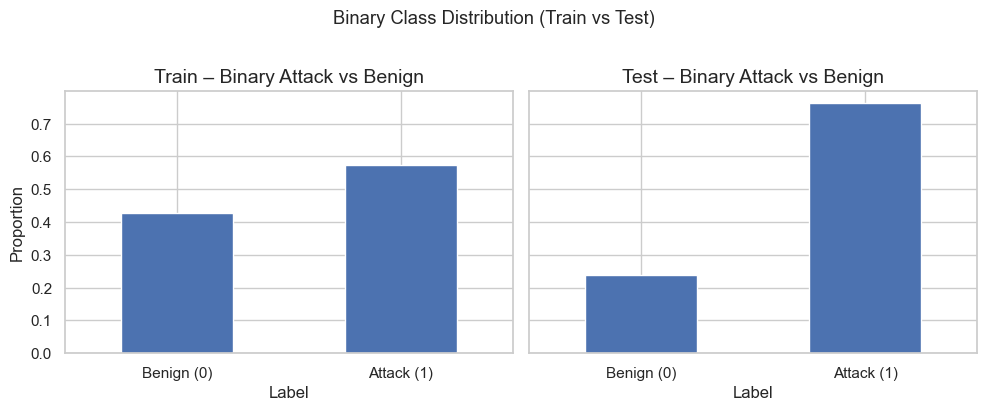

Numeric features chosen for EDA histograms: ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts']


C:\Users\agtor\AppData\Local\Temp\ipykernel_41840\1021027547.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Binary label (0=Benign, 1=Attack)")


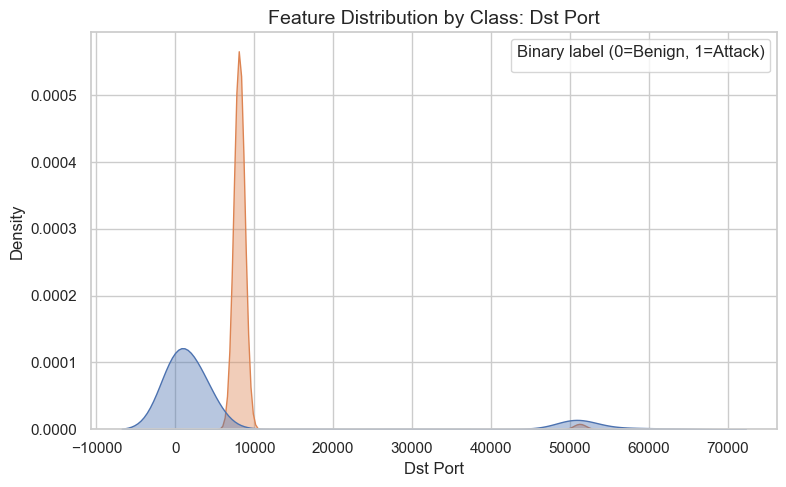

C:\Users\agtor\AppData\Local\Temp\ipykernel_41840\1021027547.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Binary label (0=Benign, 1=Attack)")


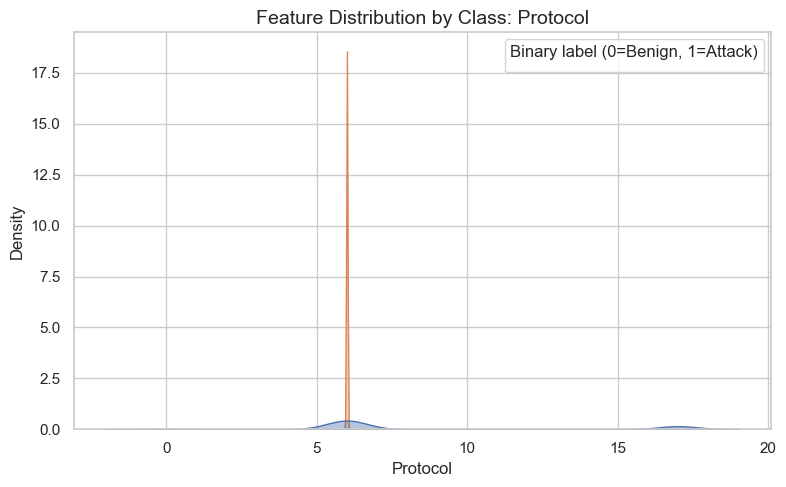

C:\Users\agtor\AppData\Local\Temp\ipykernel_41840\1021027547.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Binary label (0=Benign, 1=Attack)")


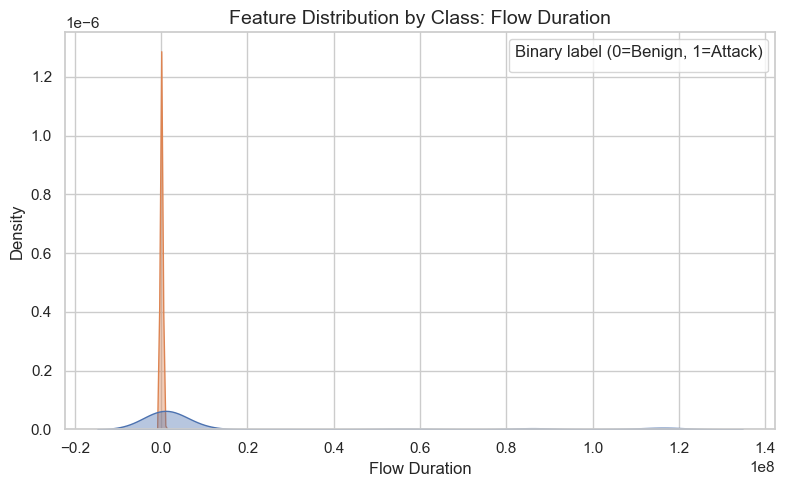

C:\Users\agtor\AppData\Local\Temp\ipykernel_41840\1021027547.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Binary label (0=Benign, 1=Attack)")


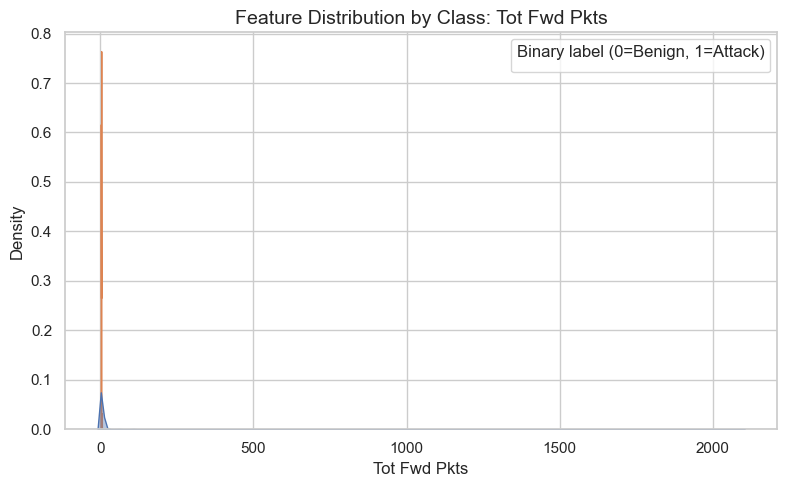

In [126]:
# ======================================================================
# Cell 14 – Cyber IDS code
# Purpose
#   - Visualize the binary Attack vs Benign class distribution for train and test splits.
#   - Select a small set of numeric features for detailed distribution analysis.
#   - Draw KDE plots for those features, comparing Benign (0) vs Attack (1) on a sampled subset.
#   - Build intuition about class imbalance and which features might separate malicious and benign flows.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Create side-by-side Matplotlib axes for binary class distribution bar plots.
#   2. Plot the training binary class proportions on the left axis.
#   3. Set the title for the training binary distribution plot.
#   4. Set the x-tick labels for the training binary plot (Benign/Attack).
#   5. Set the y-axis label (proportion) for the training binary plot.
#   6. Plot the test binary class proportions on the right axis.
#   7. Set the title for the test binary distribution plot.
#   8. Set the x-tick labels for the test binary plot (Benign/Attack).
#   9. Add an overall figure title summarizing the train vs test class distributions.
#   10. Tighten the layout to avoid overlapping elements.
#   11. Render the bar plot figure to the notebook.
#   12. Extract the list of numeric columns from the training DataFrame.
#   13. Select up to four numeric features for detailed EDA.
#   14. Print the list of numeric features chosen for EDA.
#   15. If numeric features exist, sample rows and plot KDE distributions by binary class for each feature.
#   16. If no numeric features exist, print an informative message instead of plotting.
# ======================================================================

# 1. Create side-by-side Matplotlib axes for binary class distribution bar plots.
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# 2. Plot the training binary class proportions on the left axis.
binary_train_dist.plot(kind="bar", ax=axes[0])

# 3. Set the title for the training binary distribution plot.
axes[0].set_title("Train – Binary Attack vs Benign")

# 4. Set the x-tick labels for the training binary plot (Benign/Attack).
axes[0].set_xticklabels(["Benign (0)", "Attack (1)"], rotation=0)

# 5. Set the y-axis label (proportion) for the training binary plot.
axes[0].set_ylabel("Proportion")

# 6. Plot the test binary class proportions on the right axis.
binary_test_dist.plot(kind="bar", ax=axes[1])

# 7. Set the title for the test binary distribution plot.
axes[1].set_title("Test – Binary Attack vs Benign")

# 8. Set the x-tick labels for the test binary plot (Benign/Attack).
axes[1].set_xticklabels(["Benign (0)", "Attack (1)"], rotation=0)

# 9. Add an overall figure title summarizing the train vs test class distributions.
plt.suptitle("Binary Class Distribution (Train vs Test)", y=1.02)

# 10. Tighten the layout to avoid overlapping elements.
plt.tight_layout()

# 11. Render the bar plot figure to the notebook.
plt.show()

# 12. Extract the list of numeric columns from the training DataFrame.
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# 13. Select up to four numeric features for detailed EDA.
num_features_for_eda = numeric_cols[:4] if len(numeric_cols) >= 4 else numeric_cols

# 14. Print the list of numeric features chosen for EDA.
print("Numeric features chosen for EDA histograms:", num_features_for_eda)

# 15. If numeric features exist, sample rows and plot KDE distributions by binary class for each feature.
if num_features_for_eda:
    # Sample up to 50k rows from training data to keep KDE plots tractable.
    train_sample = train_df.sample(
        n=min(50_000, len(train_df)), random_state=RANDOM_STATE
    )

    # Create binary labels for the sampled rows using the same mapping as before.
    train_sample_binary = make_binary_labels_series(
        train_sample[TARGET_COLUMN].astype(str), BENIGN_LABELS
    )

    # For each selected numeric feature, draw a KDE plot comparing Benign vs Attack distributions.
    for feature in num_features_for_eda:
        plt.figure()
        sns.kdeplot(
            data=train_sample,
            x=feature,
            hue=train_sample_binary,
            common_norm=False,
            fill=True,
            alpha=0.4,
        )
        plt.title(f"Feature Distribution by Class: {feature}")
        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.legend(title="Binary label (0=Benign, 1=Attack)")
        plt.tight_layout()
        plt.show()

# 16. If no numeric features exist, print an informative message instead of plotting.
else:
    print("No numeric columns found for histogram EDA.")


### EDA Takeaways

This short narrative section distills the main observations from the EDA:

- attack traffic is much rarer than benign flows, so plain accuracy is misleading and we focus on PR‑AUC and recall at low FPR;
- the day‑based train/test split keeps label distributions broadly similar, making it a reasonable temporal evaluation split;
- several flow‑level features (for example, byte counts, packet counts and durations) show visibly different shapes for attacks vs benign flows,
  suggesting that tree‑based models should have plenty of useful signal.


## Preprocessing & Feature Engineering (with *memory-aware* sanitization)

This section converts the raw train/test tables into clean numeric matrices that can be safely fed into machine‑learning models:

- identifies and drops obvious metadata / leakage fields such as IPs, flow IDs and timestamps;
- builds a purely numeric feature matrix and a binary Attack vs Benign target from each DataFrame;
- enforces a train/test split by day to reduce temporal leakage between scenarios;
- fits a lightweight sanitiser on `X_train` that handles NaNs, infinities and all‑missing columns in a memory‑aware way;
- applies the same sanitisation rules to `X_test` and frees the original raw DataFrames to save RAM before modelling.


In [127]:
# ======================================================================
# Cell 17 – Cyber IDS code
# Purpose
#   - Declare a configurable list of known metadata / leakage columns (timestamps, IPs, IDs).
#   - Provide a helper to find which of those leakage columns are actually present in a DataFrame.
#   - Provide a helper to convert raw labels in a DataFrame into binary Attack vs Benign form.
#   - Centralize leakage and label handling so later preprocessing code can reuse these utilities.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Declare the HARDCODED_LEAKAGE_COLUMNS list of candidate metadata/leakage columns.
#   2. Define helper function `identify_leakage_and_meta_columns` to filter present leakage columns.
#   3. Define helper function `make_binary_labels` to create a binary Attack vs Benign label series.
# ======================================================================

# 1. Declare the HARDCODED_LEAKAGE_COLUMNS list of candidate metadata/leakage columns.
HARDCODED_LEAKAGE_COLUMNS: List[str] = [
    "Flow ID",
    "Src IP",
    "Dst IP",
    "Timestamp",
]

# 2. Define helper function `identify_leakage_and_meta_columns` to filter present leakage columns.
def identify_leakage_and_meta_columns(df: pd.DataFrame) -> List[str]:
    """Identify leakage / metadata columns based on a configurable list."""
    cols_to_drop = [c for c in HARDCODED_LEAKAGE_COLUMNS if c in df.columns]
    return cols_to_drop

# 3. Define helper function `make_binary_labels` to create a binary Attack vs Benign label series.
def make_binary_labels(df: pd.DataFrame, label_col: str, benign_labels: List[str]) -> pd.Series:
    """Convert raw labels into binary Attack vs Benign representation."""
    labels = df[label_col].astype(str)
    return make_binary_labels_series(labels, benign_labels).rename("is_attack")


In [128]:
# ======================================================================
# Cell 18 – Cyber IDS code
# Purpose
#   - Transform a raw CSE-CIC-IDS2018 DataFrame into (X, y) for modeling.
#   - Drop leakage/meta columns and the raw target, keeping only numeric feature columns.
#   - Create a binary Attack vs Benign label vector using the helper defined earlier.
#   - Downcast numeric features to float32 and replace infinities with NaN for later sanitization.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define the `build_feature_matrix` helper function and its parameters.
#   2. Copy the input DataFrame to avoid mutating the original.
#   3. Build the binary target vector y (Attack vs Benign) using `make_binary_labels`.
#   4. Construct the set of columns to drop (leakage/meta + raw target).
#   5. Derive the list of candidate feature columns that are not in the drop set.
#   6. Filter those candidates to keep only columns with numeric dtypes.
#   7. Build the numeric feature matrix X and downcast to float32 to save memory.
#   8. Replace any ±inf values in X with NaN, to be handled later by the sanitizer.
#   9. Print a short summary of how many numeric features are used.
#   10. Return the pair (X, y) for downstream modeling and splitting.
# ======================================================================

# 1. Define the `build_feature_matrix` helper function and its parameters.
def build_feature_matrix(
    df: pd.DataFrame,
    drop_cols: List[str],
    target_col: str,
    benign_labels: List[str],
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Construct a numeric feature matrix X and binary target y from a raw DataFrame.

    Steps (memory-aware):
    1. Compute binary labels (Attack vs Benign).
    2. Drop metadata/leakage columns + raw target from the feature set.
    3. Keep only columns whose dtype is already numeric.
    4. Downcast to float32 to reduce memory.
    5. Replace ±inf with NaN (further cleaned later by the sanitizer).
    """

    # 2. Copy the input DataFrame to avoid mutating the original.
    df = df.copy()

    # 3. Build the binary target vector y (Attack vs Benign) using `make_binary_labels`.
    y = make_binary_labels(df, target_col, benign_labels)

    # 4. Construct the set of columns to drop (leakage/meta + raw target).
    all_drop_cols = set(drop_cols + [target_col])

    # 5. Derive the list of candidate feature columns that are not in the drop set.
    feature_cols = [c for c in df.columns if c not in all_drop_cols]

    # 6. Filter those candidates to keep only columns with numeric dtypes.
    numeric_feature_cols: List[str] = []
    for c in feature_cols:
        if np.issubdtype(df[c].dtype, np.number):
            numeric_feature_cols.append(c)

    # 7. Build the numeric feature matrix X and downcast to float32 to save memory.
    X = df[numeric_feature_cols].astype("float32")

    # 8. Replace any ±inf values in X with NaN, to be handled later by the sanitizer.
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 9. Print a short summary of how many numeric features are used.
    print(
        f"[INFO] Using {len(numeric_feature_cols)} numeric features out of {len(df.columns)} columns."
    )

    # 10. Return the pair (X, y) for downstream modeling and splitting.
    return X, y


In [129]:
# ======================================================================
# Cell 19 – Cyber IDS code
# Purpose
#   - Convert raw train/test DataFrames into numeric feature matrices and binary label vectors.
#   - Use a consistent set of leakage/meta columns across train and test when building features.
#   - Immediately apply this transformation to obtain X_train_raw, X_test_raw, y_train, y_test.
#   - Free the large raw DataFrames early to reduce memory pressure before modeling.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `train_test_split_by_day` and its return signature.
#   2. Inside the helper, detect leakage/meta columns for train and test and compute their union.
#   3. Build numeric feature matrix and binary labels for the training split using `build_feature_matrix`.
#   4. Build numeric feature matrix and binary labels for the test split using the same drop set.
#   5. Print shapes and binary class distributions, then return (X_train, X_test, y_train, y_test).
#   6. Call `train_test_split_by_day` to obtain initial raw numeric matrices and label vectors.
#   7. Free the large raw DataFrames, trigger garbage collection, and confirm memory cleanup.
# ======================================================================

# 1. Define helper function `train_test_split_by_day` and its return signature.
def train_test_split_by_day(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_col: str,
    benign_labels: List[str],
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Convert train/test DataFrames into numeric feature matrices + binary labels."""

    # 2. Inside the helper, detect leakage/meta columns for train and test and compute their union.
    leakage_cols_train = identify_leakage_and_meta_columns(train_df)
    leakage_cols_test = identify_leakage_and_meta_columns(test_df)
    leakage_cols_union = sorted(set(leakage_cols_train).union(leakage_cols_test))
    print("[INFO] Leakage/meta columns to drop:", leakage_cols_union)

    # 3. Build numeric feature matrix and binary labels for the training split using `build_feature_matrix`.
    X_train, y_train = build_feature_matrix(
        df=train_df,
        drop_cols=leakage_cols_union,
        target_col=target_col,
        benign_labels=benign_labels,
    )

    # 4. Build numeric feature matrix and binary labels for the test split using the same drop set.
    X_test, y_test = build_feature_matrix(
        df=test_df,
        drop_cols=leakage_cols_union,
        target_col=target_col,
        benign_labels=benign_labels,
    )

    # 5. Print shapes and binary class distributions, then return (X_train, X_test, y_train, y_test).
    print("X_train shape (raw numeric):", X_train.shape)
    print("X_test  shape (raw numeric):", X_test.shape)
    print("y_train distribution:", y_train.value_counts(normalize=True).to_dict())
    print("y_test  distribution:", y_test.value_counts(normalize=True).to_dict())

    return X_train, X_test, y_train, y_test


# Build initial (possibly dirty) numeric matrices
# 6. Call `train_test_split_by_day` to obtain initial raw numeric matrices and label vectors.
X_train_raw, X_test_raw, y_train, y_test = train_test_split_by_day(
    train_df=train_df,
    test_df=test_df,
    target_col=TARGET_COLUMN,
    benign_labels=BENIGN_LABELS,
)

# 7. Free the large raw DataFrames, trigger garbage collection, and confirm memory cleanup.
del train_df, test_df          # release references to the original raw DataFrames
gc.collect()                   # ask Python to reclaim memory if possible
print("\nFreed raw train/test DataFrames from memory.")


[INFO] Leakage/meta columns to drop: ['Timestamp']
[INFO] Using 78 numeric features out of 80 columns.
[INFO] Using 78 numeric features out of 80 columns.
X_train shape (raw numeric): (500000, 78)
X_test  shape (raw numeric): (500000, 78)
y_train distribution: {1: 0.572382, 0: 0.427618}
y_test  distribution: {1: 0.761898, 0: 0.238102}

Freed raw train/test DataFrames from memory.


In [130]:
# ======================================================================
# Cell 20 – Cyber IDS code
# Purpose
#   - Learn a numeric "sanitizer" from X_train: detect non-finite values and compute column medians.
#   - Drop columns that are entirely NaN/non-finite and impute remaining NaNs with medians.
#   - Return both a cleaned, float32 training matrix and a dictionary with metadata for future sanitization.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `fit_sanitizer` and its inputs/outputs.
#   2. Cast the training matrix to float64 for stable median computation.
#   3. Convert the DataFrame to a NumPy array and build a mask of non-finite values (NaN/±inf).
#   4. If non-finite values exist, replace them with NaN and log how many were fixed.
#   5. Compute column-wise medians while ignoring NaNs.
#   6. Identify columns whose medians are NaN (i.e., all-NaN/all-non-finite columns).
#   7. If such columns exist, drop them from the array/metadata and log their names.
#   8. Otherwise, keep the full column list as-is.
#   9. Build a NaN mask on the remaining array and impute NaNs with the corresponding column medians.
#   10. Print a diagnostic line confirming there are no remaining NaNs/±inf in the array.
#   11. Cast the cleaned array back to float32 and rebuild a sanitized DataFrame with original index.
#   12. Create a `sanitizer` dictionary holding columns, medians, and a name identifier.
#   13. Return both the sanitizer dictionary and the cleaned training DataFrame.
# ======================================================================

# 1. Define helper function `fit_sanitizer` and its inputs/outputs.
def fit_sanitizer(X_train: pd.DataFrame, name: str = "X_train") -> Tuple[Dict[str, Any], pd.DataFrame]:
    """
    Fit a sanitization mapping on the training matrix.

    Returns a dict containing:
    - columns: list of kept column names (in order)
    - medians: list of column medians (for imputation)
    - name: identifier (for logging)

    and the sanitized training DataFrame.
    """

    # 2. Cast the training matrix to float64 for stable median computation.
    X_num = X_train.astype("float64", copy=False)

    # 3. Convert the DataFrame to a NumPy array and build a mask of non-finite values (NaN/±inf).
    arr = X_num.to_numpy()
    non_finite_mask = ~np.isfinite(arr)

    # 4. If non-finite values exist, replace them with NaN and log how many were fixed.
    if non_finite_mask.any():
        print(f"[WARN] {name}: found {non_finite_mask.sum()} non-finite values; converting to NaN.")
        arr[non_finite_mask] = np.nan

    # 5. Compute column-wise medians while ignoring NaNs.
    col_medians = np.nanmedian(arr, axis=0)

    # 6. Identify columns whose medians are NaN (i.e., all-NaN/all-non-finite columns).
    nan_median_mask = np.isnan(col_medians)

    # 7. If such columns exist, drop them from the array/metadata and log their names.
    if nan_median_mask.any():
        drop_cols = [c for c, drop in zip(X_num.columns, nan_median_mask) if drop]
        print(f"[INFO] {name}: dropping {len(drop_cols)} all-NaN/all-non-finite columns:")
        print("       ", drop_cols)

        keep_mask = ~nan_median_mask
        arr = arr[:, keep_mask]
        col_medians = col_medians[keep_mask]
        columns = [c for c, keep in zip(X_num.columns, keep_mask) if keep]

    # 8. Otherwise, keep the full column list as-is.
    else:
        columns = list(X_num.columns)

    # 9. Build a NaN mask on the remaining array and impute NaNs with the corresponding column medians.
    nan_mask = np.isnan(arr)
    if nan_mask.any():
        print(f"[INFO] {name}: imputing {nan_mask.sum()} NaNs with column medians.")
        inds = np.where(nan_mask)
        arr[inds] = col_medians[inds[1]]

    # 10. Print a diagnostic line confirming there are no remaining NaNs/±inf in the array.
    print(
        f"[INFO] {name} (after fit): any NaN? {np.isnan(arr).any()}, any inf? {np.isinf(arr).any()}"
    )

    # 11. Cast the cleaned array back to float32 and rebuild a sanitized DataFrame with original index.
    arr = arr.astype("float32")
    X_train_clean = pd.DataFrame(arr, columns=columns, index=X_train.index)

    # 12. Create a `sanitizer` dictionary holding columns, medians, and a name identifier.
    sanitizer = {
        "columns": columns,
        "medians": col_medians.tolist(),  # still float64, fine
        "name": name,
    }

    # 13. Return both the sanitizer dictionary and the cleaned training DataFrame.
    return sanitizer, X_train_clean


In [131]:
# ======================================================================
# Cell 21 – Cyber IDS code
# Purpose
#   - Define and apply a helper that cleans X_test using the sanitizer fitted on X_train.
#   - Ensure train and test matrices undergo identical inf/NaN handling based on training medians.
#   - Free the raw, unsanitized matrices to save memory and print final numeric sanity checks.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `apply_sanitizer` and describe its behavior.
#   2. Inside the helper, extract training columns and medians from the `sanitizer` dict.
#   3. Reindex the new DataFrame to training columns, cast to float64, and build a NumPy array.
#   4. Detect non-finite values (NaN/±inf) in the array, replace them with NaN, and log a warning if needed.
#   5. Detect remaining NaNs, impute them with training medians, and log how many were imputed.
#   6. Print a diagnostic line summarizing whether any NaNs/±inf remain after sanitization.
#   7. Cast the sanitized array to float32 and rebuild a cleaned DataFrame aligned with the original index.
#   8. Fit the sanitizer on X_train_raw and obtain the cleaned X_train matrix.
#   9. Apply the same sanitizer to X_test_raw to obtain the cleaned X_test matrix.
#   10. Delete the raw matrices, trigger garbage collection, and log that memory was freed.
#   11. Print shapes and NaN/inf sanity checks for the cleaned X_train and X_test matrices.
# ======================================================================

# 1. Define helper function `apply_sanitizer` and describe its behavior.
def apply_sanitizer(X: pd.DataFrame, sanitizer: Dict[str, Any], name: str = "X_test") -> pd.DataFrame:
    """
    Apply a previously fitted sanitization mapping to a new matrix (e.g., test).

    - Reindexes columns to match training.
    - Converts non-finite to NaN.
    - Imputes NaNs with training medians.
    """

    # 2. Inside the helper, extract training columns and medians from the `sanitizer` dict.
    columns = sanitizer["columns"]
    medians = np.array(sanitizer["medians"], dtype="float64")

    # 3. Reindex the new DataFrame to training columns, cast to float64, and build a NumPy array.
    X_num = X.reindex(columns=columns).astype("float64", copy=False)
    arr = X_num.to_numpy()

    # 4. Detect non-finite values (NaN/±inf) in the array, replace them with NaN, and log a warning if needed.
    non_finite_mask = ~np.isfinite(arr)
    if non_finite_mask.any():
        print(f"[WARN] {name}: found {non_finite_mask.sum()} non-finite values; converting to NaN.")
        arr[non_finite_mask] = np.nan

    # 5. Detect remaining NaNs, impute them with training medians, and log how many were imputed.
    nan_mask = np.isnan(arr)
    if nan_mask.any():
        print(f"[INFO] {name}: imputing {nan_mask.sum()} NaNs with training medians.")
        inds = np.where(nan_mask)
        arr[inds] = medians[inds[1]]

    # 6. Print a diagnostic line summarizing whether any NaNs/±inf remain after sanitization.
    print(
        f"[INFO] {name} (after apply): any NaN? {np.isnan(arr).any()}, any inf? {np.isinf(arr).any()}"
    )

    # 7. Cast the sanitized array to float32 and rebuild a cleaned DataFrame aligned with the original index.
    arr = arr.astype("float32")
    return pd.DataFrame(arr, columns=columns, index=X.index)


# 8. Fit the sanitizer on X_train_raw and obtain the cleaned X_train matrix.
sanitizer, X_train = fit_sanitizer(X_train_raw, name="X_train")

# 9. Apply the same sanitizer to X_test_raw to obtain the cleaned X_test matrix.
X_test = apply_sanitizer(X_test_raw, sanitizer, name="X_test")

# 10. Delete the raw matrices, trigger garbage collection, and log that memory was freed.
del X_train_raw, X_test_raw
gc.collect()

# 11. Print shapes and NaN/inf sanity checks for the cleaned X_train and X_test matrices.
print("X_train shape (clean):", X_train.shape)
print("X_test  shape (clean):", X_test.shape)

print("X_train – any NaN? ", np.isnan(X_train.to_numpy()).any())
print("X_train – any inf? ", np.isinf(X_train.to_numpy()).any())

print("X_test  – any NaN? ", np.isnan(X_test.to_numpy()).any())
print("X_test  – any inf? ", np.isinf(X_test.to_numpy()).any())


[WARN] X_train: found 2388 non-finite values; converting to NaN.
[INFO] X_train: imputing 2388 NaNs with column medians.
[INFO] X_train (after fit): any NaN? False, any inf? False
[WARN] X_test: found 1374 non-finite values; converting to NaN.
[INFO] X_test: imputing 1374 NaNs with training medians.
[INFO] X_test (after apply): any NaN? False, any inf? False
X_train shape (clean): (500000, 78)
X_test  shape (clean): (500000, 78)
X_train – any NaN?  False
X_train – any inf?  False
X_test  – any NaN?  False
X_test  – any inf?  False


## Metrics & Evaluation Utilities

This section defines reusable evaluation helpers used throughout the notebook:

- computes common classification metrics (accuracy, precision, recall, F1‑macro, ROC‑AUC, PR‑AUC) from predicted probabilities;
- derives recall at a target false‑positive rate using the ROC curve (for example, 1% FPR);
- plots precision–recall and ROC curves for visual comparison of models;
- draws reliability (calibration) diagrams to inspect how well predicted probabilities match observed frequencies.


In [132]:
# ======================================================================
# Cell 23 – Cyber IDS code
# Purpose
#   - Implement reusable evaluation helpers for PR-AUC, ROC-AUC, F1, and related metrics.
#   - Provide a function to compute recall at a target false positive rate (e.g., 1% FPR).
#   - Standardize how we score and compare different models in the notebook.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `compute_basic_metrics`.
#   2. Execute the main code logic for this stage of the Cyber IDS workflow.
# ======================================================================

# 1. Define helper function `compute_basic_metrics`.
def compute_basic_metrics(
    y_true: np.ndarray,
    y_proba: np.ndarray,
    threshold: float = 0.5,
# 2. Execute the main code logic for this stage of the Cyber IDS workflow.
) -> Dict[str, float]:
    """Compute common binary classification metrics given probabilities + threshold."""
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_macro": f1_macro,
        "roc_auc": roc,
        "pr_auc": pr_auc,
    }

In [133]:
# ======================================================================
# Cell 24 – Cyber IDS code
# Purpose
#   - Implement a helper to compute recall at a target false positive rate (e.g., 1% FPR).
#   - Use the ROC curve (FPR/TPR/thresholds) to choose an operating threshold.
#   - Provide a standardized way to compare models under strict low-FPR constraints.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `compute_recall_at_fpr` and its parameters.
#   2. Compute the ROC curve (FPR, TPR, thresholds) from true labels and scores.
#   3. Identify ROC points whose FPR is less than or equal to the target FPR.
#   4. Handle the edge case where no ROC point satisfies FPR <= target (pick the closest point).
#   5. Otherwise, pick the ROC point with the highest FPR still <= target and read recall/threshold.
#   6. Return the pair (recall_at_target_fpr, chosen_threshold) to the caller.
# ======================================================================

# 1. Define helper function `compute_recall_at_fpr` and its parameters.
def compute_recall_at_fpr(
    y_true: np.ndarray,
    y_score: np.ndarray,
    target_fpr: float = 0.01,
) -> Tuple[float, float]:
    """Return (recall_at_target_fpr, threshold) using the ROC curve."""

    # 2. Compute the ROC curve (FPR, TPR, thresholds) from true labels and scores.
    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # 3. Identify ROC points whose FPR is less than or equal to the target FPR.
    valid_indices = np.where(fpr <= target_fpr)[0]

    # 4. Handle the edge case where no ROC point satisfies FPR <= target (pick the closest point).
    if len(valid_indices) == 0:
        min_fpr_idx = np.argmin(fpr)
        return float(tpr[min_fpr_idx]), float(thresholds[min_fpr_idx])

    # 5. Otherwise, pick the ROC point with the highest FPR still <= target and read recall/threshold.
    chosen_idx = valid_indices[-1]
    recall_at_target = float(tpr[chosen_idx])
    chosen_threshold = float(thresholds[chosen_idx])

    # 6. Return the pair (recall_at_target_fpr, chosen_threshold) to the caller.
    return recall_at_target, chosen_threshold


In [134]:
# ======================================================================
# Cell 25 – Cyber IDS code
# Purpose
#   - Define a helper function that plots the precision–recall (PR) curve for any model.
#   - Compute and display the average precision (AP) as a scalar summary of PR performance.
#   - Standardize how PR curves are visualized across different models in this notebook.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `plot_pr_curve` and its parameters.
#   2. Compute precision–recall points and the average precision (AP) from true labels and scores.
#   3. Create a new figure and plot the PR curve with AP in the legend label.
#   4. Label axes, set the title, and add legend/grid for readability.
#   5. Apply a tight layout and render the plot on screen.
# ======================================================================

# 1. Define helper function `plot_pr_curve` and its parameters.
def plot_pr_curve(y_true: np.ndarray, y_score: np.ndarray, title: str = "PR Curve") -> None:
    # 2. Compute precision–recall points and the average precision (AP) from true labels and scores.
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    # 3. Create a new figure and plot the PR curve with AP in the legend label.
    plt.figure()
    plt.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")

    # 4. Label axes, set the title, and add legend/grid for readability.
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # 5. Apply a tight layout and render the plot on screen.
    plt.tight_layout()
    plt.show()


In [135]:
# ======================================================================
# Cell 26 – Cyber IDS code
# Purpose
#   - Define a helper function that plots the ROC curve for any binary classifier.
#   - Compute and display ROC-AUC so we can compare models visually against a random baseline.
#   - Standardize how ROC curves are generated and annotated across the notebook.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `plot_roc_curve` and its parameters.
#   2. Compute the ROC points (FPR, TPR) and ROC-AUC from true labels and scores.
#   3. Create a new figure and plot the ROC curve, including AUC in the legend label.
#   4. Add a diagonal "random guess" reference line for visual comparison.
#   5. Label axes, set the title, add legend and grid for readability.
#   6. Apply a tight layout and render the plot on screen.
# ======================================================================

# 1. Define helper function `plot_roc_curve` and its parameters.
def plot_roc_curve(y_true: np.ndarray, y_score: np.ndarray, title: str = "ROC Curve") -> None:
    # 2. Compute the ROC points (FPR, TPR) and ROC-AUC from true labels and scores.
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    # 3. Create a new figure and plot the ROC curve, including AUC in the legend label.
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")

    # 4. Add a diagonal "random guess" reference line for visual comparison.
    plt.plot([0, 1], [0, 1], "k--", label="Random")

    # 5. Label axes, set the title, add legend and grid for readability.
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # 6. Apply a tight layout and render the plot on screen.
    plt.tight_layout()
    plt.show()


In [136]:
# ======================================================================
# Cell 27 – Cyber IDS code
# Purpose
#   - Define a helper to visualize probability calibration using a reliability diagram.
#   - Show, for binned predicted probabilities, how often positives actually occur.
#   - Make it easy to compare raw vs calibrated probabilities for any binary classifier.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `plot_calibration_curve` and its parameters.
#   2. Compute calibration curve points (predicted probability bins vs observed positive rates).
#   3. Create a new figure and plot the model’s calibration curve as a line with markers.
#   4. Add a diagonal “perfectly calibrated” reference line for comparison.
#   5. Label axes, set the title, and add legend/grid for readability.
#   6. Apply a tight layout and render the plot on screen.
# ======================================================================

# 1. Define helper function `plot_calibration_curve` and its parameters.
def plot_calibration_curve(
    y_true: np.ndarray,
    y_proba: np.ndarray,
    n_bins: int = 10,
    title: str = "Calibration curve (reliability diagram)",
) -> None:
    # 2. Compute calibration curve points (predicted probability bins vs observed positive rates).
    prob_true, prob_pred = calibration_curve(
        y_true,
        y_proba,
        n_bins=n_bins,
        strategy="uniform",
    )

    # 3. Create a new figure and plot the model’s calibration curve as a line with markers.
    plt.figure()
    plt.plot(prob_pred, prob_true, "s-", label="Model")

    # 4. Add a diagonal “perfectly calibrated” reference line for comparison.
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

    # 5. Label axes, set the title, and add legend/grid for readability.
    plt.xlabel("Predicted probability (binned)")
    plt.ylabel("Observed fraction of positives")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # 6. Apply a tight layout and render the plot on screen.
    plt.tight_layout()
    plt.show()


## Baselines: Majority Class & Logistic Regression

This section trains and evaluates simple baseline models before moving on to tree‑based ensembles:

- evaluates a trivial majority‑class baseline that always predicts Benign, establishing a lower bound on performance;
- builds a scikit‑learn pipeline with standard scaling and class‑weighted Logistic Regression;
- trains the Logistic Regression on the sanitized features and scores it on the held‑out test set;
- reports PR‑AUC, ROC‑AUC, F1 and recall at 1% FPR and plots PR/ROC curves for the logistic baseline.


In [137]:
# ======================================================================
# Cell 29 – Cyber IDS code
# Purpose
#   - Implement a trivial baseline that always predicts the majority (Benign) class.
#   - Compute standard metrics and recall@1% FPR to establish a lower-bound reference.
#   - Use this baseline as a sanity check and comparison point for more complex models.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `evaluate_majority_baseline` and explain its role.
#   2. Inside the helper, find the majority class in y_train and warn if it is not 0 (Benign).
#   3. Build an all-zero score vector for y_test (probability of Attack = 0.0 for every example).
#   4. Compute standard metrics on this baseline using `compute_basic_metrics`.
#   5. Compute recall@1% FPR (and the corresponding threshold) using `compute_recall_at_fpr`.
#   6. Print a human-readable summary of baseline performance and return a metrics dictionary.
#   7. Call `evaluate_majority_baseline` on the current train/test labels and store the result.
# ======================================================================

# 1. Define helper function `evaluate_majority_baseline` and explain its role.
def evaluate_majority_baseline(y_train: pd.Series, y_test: pd.Series) -> Dict[str, float]:
    """Evaluate a trivial baseline that always predicts the majority (usually Benign)."""

    # 2. Inside the helper, find the majority class in y_train and warn if it is not 0 (Benign).
    majority_class = int(y_train.value_counts().idxmax())
    if majority_class != 0:
        print("[WARN] Majority class is not 0 (Benign).")

    # 3. Build an all-zero score vector for y_test (probability of Attack = 0.0 for every example).
    y_score = np.zeros_like(y_test, dtype=float)

    # 4. Compute standard metrics on this baseline using `compute_basic_metrics`.
    metrics = compute_basic_metrics(y_true=y_test.values, y_proba=y_score, threshold=0.5)

    # 5. Compute recall@1% FPR (and the corresponding threshold) using `compute_recall_at_fpr`.
    rec_at_fpr, thr = compute_recall_at_fpr(
        y_true=y_test.values,
        y_score=y_score,
        target_fpr=0.01,
    )

    # 6. Print a human-readable summary of baseline performance and return a metrics dictionary.
    print("=== Majority Baseline (predict all Benign) ===")
    print("Metrics:", metrics)
    print("Recall@1% FPR:", rec_at_fpr, "Threshold used:", thr)

    return {
        **metrics,
        "recall_at_1_fpr": rec_at_fpr,
        "threshold_at_1_fpr": thr,
    }

# 7. Call `evaluate_majority_baseline` on the current train/test labels and store the result.
majority_metrics = evaluate_majority_baseline(y_train=y_train, y_test=y_test)


[WARN] Majority class is not 0 (Benign).
=== Majority Baseline (predict all Benign) ===
Metrics: {'accuracy': 0.238102, 'precision': 0.0, 'recall': 0.0, 'f1_macro': 0.19231210352620381, 'roc_auc': np.float64(0.5), 'pr_auc': np.float64(0.761898)}
Recall@1% FPR: 0.0 Threshold used: inf


In [138]:
# ======================================================================
# Cell 30 – Cyber IDS code
# Purpose
#   - Build a scikit-learn pipeline for a Logistic Regression baseline classifier.
#   - Standardize all numeric features before modeling to improve optimization.
#   - Use class_weight="balanced" to partially correct for class imbalance.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `build_logistic_regression_pipeline` and its input parameter.
#   2. Inside the function, create a numeric preprocessing sub-pipeline with StandardScaler.
#   3. Wrap the numeric transformer in a ColumnTransformer that selects numeric_features.
#   4. Configure a LogisticRegression classifier with class_weight="balanced" and fixed RNG.
#   5. Combine the preprocessor and classifier into a single Pipeline and return it.
# ======================================================================

# 1. Define helper function `build_logistic_regression_pipeline` and its input parameter.
def build_logistic_regression_pipeline(numeric_features: List[str]) -> Pipeline:
    """Pipeline: standardize numeric features + LogisticRegression(balanced)."""

    # 2. Inside the function, create a numeric preprocessing sub-pipeline with StandardScaler.
    numeric_transformer = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
        ]
    )

    # 3. Wrap the numeric transformer in a ColumnTransformer that selects numeric_features.
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
        ],
        remainder="drop",
    )

    # 4. Configure a LogisticRegression classifier with class_weight="balanced" and fixed RNG.
    log_reg = LogisticRegression(
        class_weight="balanced",
        max_iter=1_000,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    # 5. Combine the preprocessor and classifier into a single Pipeline and return it.
    clf = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", log_reg),
        ]
    )

    return clf


=== Logistic Regression Baseline ===
Metrics: {'accuracy': 0.232448, 'precision': 0.0, 'recall': 0.0, 'f1_macro': 0.1886067404060861, 'roc_auc': np.float64(0.06847930535822311), 'pr_auc': np.float64(0.5823819134408635)}
Recall@1% FPR: 0.0 Threshold: 0.9864926355923673


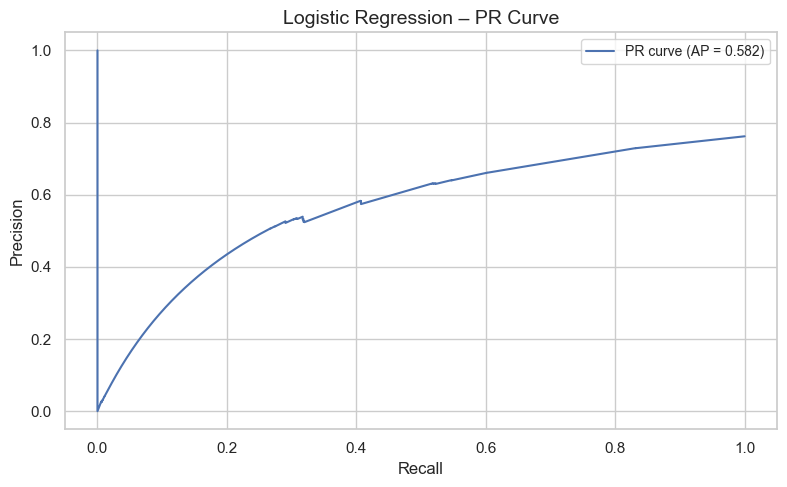

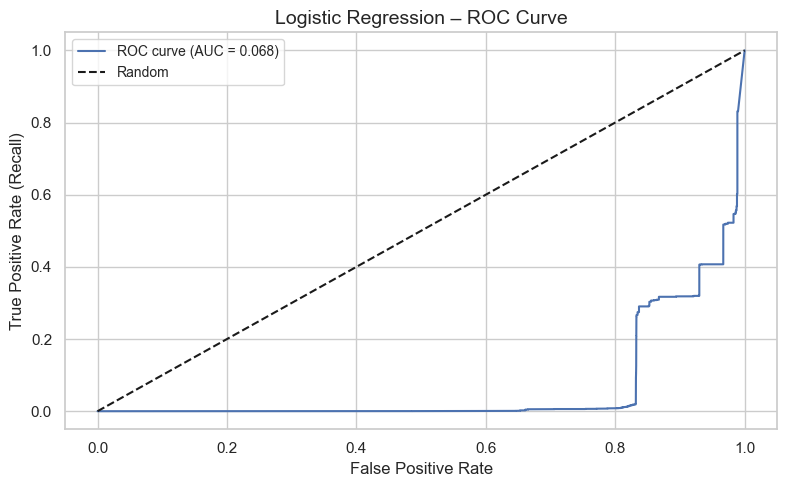

In [139]:
# ======================================================================
# Cell 31 – Cyber IDS code
# Purpose
#   - Train the Logistic Regression baseline on the sanitized feature matrices.
#   - Evaluate it on the test set with PR-AUC, ROC-AUC, F1, and recall@1% FPR.
#   - Plot PR and ROC curves to compare against tree-based models later.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Collect the list of numeric feature names from X_train columns.
#   2. Build a Logistic Regression pipeline using the numeric feature list.
#   3. Fit the pipeline on the cleaned training data (X_train, y_train).
#   4. Generate predicted probabilities for the Attack class on X_test.
#   5. Compute standard metrics (accuracy, precision, recall, F1, ROC-AUC, PR-AUC).
#   6. Compute recall at 1% false positive rate and the corresponding threshold.
#   7. Print a readable summary of the Logistic Regression baseline metrics.
#   8. Plot the Precision–Recall curve for the Logistic Regression baseline.
#   9. Plot the ROC curve for the Logistic Regression baseline.
# ======================================================================

# 1. Collect the list of numeric feature names from X_train columns.
numeric_features = X_train.columns.tolist()

# 2. Build a Logistic Regression pipeline using the numeric feature list.
log_reg_pipeline = build_logistic_regression_pipeline(numeric_features=numeric_features)

# 3. Fit the pipeline on the cleaned training data (X_train, y_train).
log_reg_pipeline.fit(X_train, y_train)

# 4. Generate predicted probabilities for the Attack class on X_test.
log_reg_proba_test = log_reg_pipeline.predict_proba(X_test)[:, 1]

# 5. Compute standard metrics (accuracy, precision, recall, F1, ROC-AUC, PR-AUC).
log_reg_metrics = compute_basic_metrics(
    y_true=y_test.values,
    y_proba=log_reg_proba_test,
    threshold=0.5,
)

# 6. Compute recall at 1% false positive rate and the corresponding threshold.
rec_at_1_fpr_lr, thr_at_1_fpr_lr = compute_recall_at_fpr(
    y_true=y_test.values,
    y_score=log_reg_proba_test,
    target_fpr=0.01,
)

# 7. Print a readable summary of the Logistic Regression baseline metrics.
print("=== Logistic Regression Baseline ===")
print("Metrics:", log_reg_metrics)
print("Recall@1% FPR:", rec_at_1_fpr_lr, "Threshold:", thr_at_1_fpr_lr)

# 8. Plot the Precision–Recall curve for the Logistic Regression baseline.
plot_pr_curve(
    y_true=y_test.values,
    y_score=log_reg_proba_test,
    title="Logistic Regression – PR Curve",
)

# 9. Plot the ROC curve for the Logistic Regression baseline.
plot_roc_curve(
    y_true=y_test.values,
    y_score=log_reg_proba_test,
    title="Logistic Regression – ROC Curve",
)


### Baseline Takeaways

This narrative section highlights what we learn from the majority and logistic baselines:

- predicting “all Benign” typically yields reasonable accuracy but near‑zero recall on attacks, so it is not acceptable for IDS use;
- Logistic Regression, even with class weighting and scaling, usually improves recall and PR‑AUC but may still struggle at very low FPR;
- these results motivate trying more expressive models (RandomForest and XGBoost) that can capture nonlinear relationships between flow features.


## Tree Ensembles: Random Forest & XGBoost

This section trains stronger tree‑based models and tunes their hyperparameters:

- defines randomized hyperparameter searches for RandomForest and XGBoost that run on a stratified subsample of the training data;
- runs the searches using PR‑AUC as the primary objective and then refits the best configurations on the full training set;
- evaluates both models on the test set, computing PR‑AUC, ROC‑AUC and recall at 1% FPR and plotting PR/ROC curves;
- visualises feature importances to highlight which flow features are most influential for each ensemble.


In [140]:
# ======================================================================
# Cell 34 – Cyber IDS code
# Purpose
#   - Define a helper that optionally subsamples the training data for faster hyperparameter search.
#   - Preserve class balance via stratified sampling while reducing runtime on very large datasets.
#   - Allow turning subsampling off by setting max_samples=None or using a small dataset.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `subsample_for_search` and its parameters.
#   2. Inside the helper, compute the current number of rows and check against max_samples.
#   3. If subsampling is not needed, print an informational message and return X, y unchanged.
#   4. If subsampling is needed, compute the sampling fraction and run a stratified split.
#   5. Print a summary of the subsampled size vs original and return X_sub, y_sub.
# ======================================================================

# 1. Define helper function `subsample_for_search` and its parameters.
def subsample_for_search(
    X: pd.DataFrame,
    y: pd.Series,
    max_samples: int = 200_000,
    random_state: int = 42,
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Subsample X, y for hyperparameter search.

    - Keeps up to max_samples rows.
    - Stratified by y to preserve class imbalance structure.
    """

    # 2. Inside the helper, compute the current number of rows and check against max_samples.
    n_samples = len(X)

    # 3. If subsampling is not needed, print an informational message and return X, y unchanged.
    if max_samples is None or n_samples <= max_samples:
        print(f"[INFO] Using full training set for search: {n_samples:,} rows.")
        return X, y

    # 4. If subsampling is needed, compute the sampling fraction and run a stratified split.
    frac = max_samples / n_samples
    X_sub, _, y_sub, _ = train_test_split(
        X,
        y,
        train_size=frac,
        stratify=y,
        random_state=random_state,
    )

    # 5. Print a summary of the subsampled size vs original and return X_sub, y_sub.
    print(
        f"[INFO] Subsampled training set for search: {len(X_sub):,} rows "
        f"(original {n_samples:,})."
    )
    return X_sub, y_sub


In [141]:
# ======================================================================
# Cell 35 – Cyber IDS code
# Purpose
#   - Define a faster randomized hyperparameter search procedure for RandomForest.
#   - Run the search on a stratified subsample of the training data to reduce runtime.
#   - Refit the best-found configuration on the full training set for final use.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `random_search_rf` and its configuration parameters.
#   2. Inside the helper, optionally subsample X_train, y_train for faster search.
#   3. Configure a base RandomForestClassifier used during the hyperparameter search.
#   4. Specify a trimmed hyperparameter search space and run RandomizedSearchCV (PR-AUC scoring).
#   5. Refit the best RF configuration on the full training data and return the trained model.
# ======================================================================

# 1. Define helper function `random_search_rf` and its configuration parameters.
def random_search_rf(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    n_iter: int = 5,
    max_search_samples: int = 200_000,
    n_jobs_search: int = 2,
) -> RandomForestClassifier:
    """
    Faster Randomized search for RandomForest.

    - Runs on a subsample of X_train.
    - Uses fewer iterations and a trimmed parameter space.
    """

    # 2. Inside the helper, optionally subsample X_train, y_train for faster search.
    X_sub, y_sub = subsample_for_search(
        X_train,
        y_train,
        max_samples=max_search_samples,
        random_state=RANDOM_STATE,
    )

    # 3. Configure a base RandomForestClassifier used during the hyperparameter search.
    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        n_jobs=n_jobs_search,
        class_weight="balanced_subsample",
    )

    # 4. Specify a trimmed hyperparameter search space and run RandomizedSearchCV (PR-AUC scoring).
    param_distributions = {
        "n_estimators": [100, 200],   # smaller during search
        "max_depth": [10, 20],        # no 'None' → shallower trees, faster
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt"],     # fixed; we skip 'log2' to save time
    }

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="average_precision",
        n_jobs=n_jobs_search,
        cv=2,                         # 2-fold CV instead of 3 to reduce cost
        random_state=RANDOM_STATE,
        verbose=1,
    )

    search.fit(X_sub, y_sub)
    print("Best RF params (search):", search.best_params_)
    print("Best RF PR-AUC (cv):", search.best_score_)

    # 5. Refit the best RF configuration on the full training data and return the trained model.
    best_params = search.best_params_.copy()
    # Optionally boost n_estimators a bit for the final model
    best_params["n_estimators"] = max(300, best_params.get("n_estimators", 200))

    best_rf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=n_jobs_search,
        class_weight="balanced_subsample",
        **best_params,
    )
    print("[INFO] Re-fitting best RF on full training data...")
    best_rf.fit(X_train, y_train)

    return best_rf


In [142]:
# ======================================================================
# Cell 36 – Cyber IDS code
# Purpose
#   - Define a faster randomized hyperparameter search procedure for XGBoost.
#   - Run the search on a stratified subsample of the training data to reduce runtime.
#   - Use PR-AUC as the primary scoring metric and refit the best config on full data.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `random_search_xgb` and its configuration parameters.
#   2. Inside the helper, optionally subsample X_train, y_train for faster search.
#   3. Compute the class imbalance ratio and log it (for scale_pos_weight).
#   4. Configure a base XGBClassifier used during the hyperparameter search.
#   5. Specify a trimmed hyperparameter search space that includes scale_pos_weight.
#   6. Run RandomizedSearchCV with PR-AUC scoring on the subsample and report best results.
#   7. Build best_params for the final model (optionally bumping n_estimators).
#   8. Refit the best XGB configuration on the full training data and return the trained model.
# ======================================================================

# 1. Define helper function `random_search_xgb` and its configuration parameters.
def random_search_xgb(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    n_iter: int = 5,
    max_search_samples: int = 200_000,
    n_jobs_search: int = 2,
) -> XGBClassifier:
    """
    Faster Randomized search for XGBoost.

    - Runs on a subsample of X_train.
    - Uses fewer iterations / folds and a tighter parameter space.
    """

    # 2. Inside the helper, optionally subsample X_train, y_train for faster search.
    X_sub, y_sub = subsample_for_search(
        X_train,
        y_train,
        max_samples=max_search_samples,
        random_state=RANDOM_STATE,
    )

    # 3. Compute the class imbalance ratio and log it (for scale_pos_weight).
    pos_ratio = y_train.mean()
    if pos_ratio == 0:
        raise ValueError("No positive examples in y_train. Check data and labels.")
    imbalance_ratio = (1 - pos_ratio) / pos_ratio
    print(f"[INFO] Imbalance ratio (neg/pos): {imbalance_ratio:.2f}")

    # 4. Configure a base XGBClassifier used during the hyperparameter search.
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=RANDOM_STATE,
        n_jobs=n_jobs_search,
        tree_method="hist",
    )

    # 5. Specify a trimmed hyperparameter search space that includes scale_pos_weight.
    param_distributions = {
        "n_estimators": [150, 300],           # slightly smaller during search
        "max_depth": [4, 6],                  # narrow depth range
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "scale_pos_weight": [
            max(1, int(imbalance_ratio)),
            max(1, int(imbalance_ratio * 2)),
        ],
    }

    # 6. Run RandomizedSearchCV with PR-AUC scoring on the subsample and report best results.
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="average_precision",
        n_jobs=n_jobs_search,
        cv=2,                             # 2-fold CV to reduce cost
        random_state=RANDOM_STATE,
        verbose=1,
    )

    search.fit(X_sub, y_sub)
    print("Best XGB params (search):", search.best_params_)
    print("Best XGB PR-AUC (cv):", search.best_score_)

    # 7. Build best_params for the final model (optionally bumping n_estimators).
    best_params = search.best_params_.copy()
    # For final fit, slightly bump n_estimators if desired
    best_params["n_estimators"] = max(300, best_params.get("n_estimators", 150))

    # 8. Refit the best XGB configuration on the full training data and return the trained model.
    best_xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=RANDOM_STATE,
        n_jobs=n_jobs_search,
        tree_method="hist",
        **best_params,
    )

    print("[INFO] Re-fitting best XGB on full training data...")
    best_xgb.fit(X_train, y_train)

    return best_xgb


[INFO] Subsampled training set for search: 200,000 rows (original 500,000).
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best RF params (search): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
Best RF PR-AUC (cv): 0.9999998325924221
[INFO] Re-fitting best RF on full training data...
[INFO] Subsampled training set for search: 200,000 rows (original 500,000).
[INFO] Imbalance ratio (neg/pos): 0.75
Fitting 2 folds for each of 5 candidates, totalling 10 fits


C:\Users\agtor\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [21:53:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params (search): {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best XGB PR-AUC (cv): 0.9999996579277798
[INFO] Re-fitting best XGB on full training data...


C:\Users\agtor\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [21:53:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Random Forest on Test ===
{'accuracy': 0.238086, 'precision': 0.0, 'recall': 0.0, 'f1_macro': 0.19230166563550513, 'roc_auc': np.float64(0.8310229855611663), 'pr_auc': np.float64(0.9245434612335183)}
Recall@1% FPR: 0.0 Threshold: 0.0734696173772958

=== XGBoost on Test ===
{'accuracy': 0.238078, 'precision': 0.0, 'recall': 0.0, 'f1_macro': 0.19229644658898712, 'roc_auc': np.float64(0.6539476766153416), 'pr_auc': np.float64(0.8406599263889536)}
Recall@1% FPR: 0.0 Threshold: 0.0002392480382695794


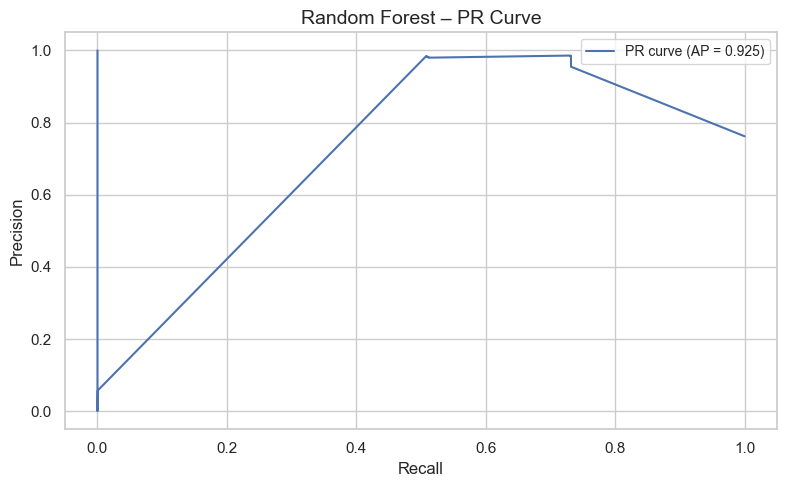

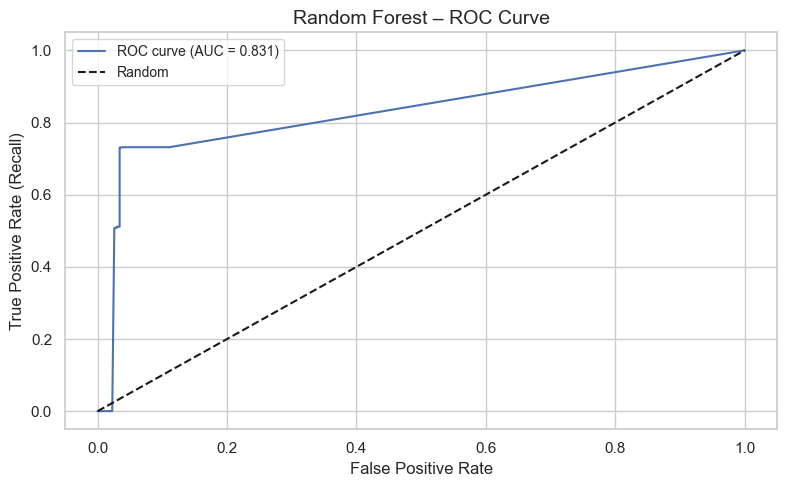

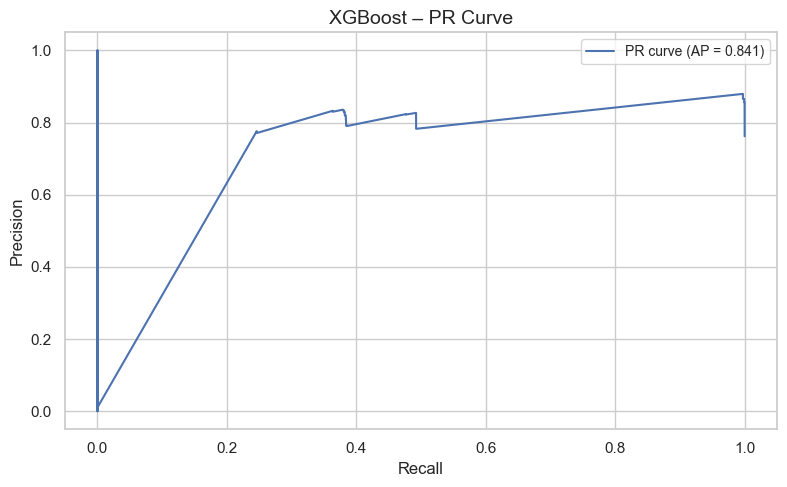

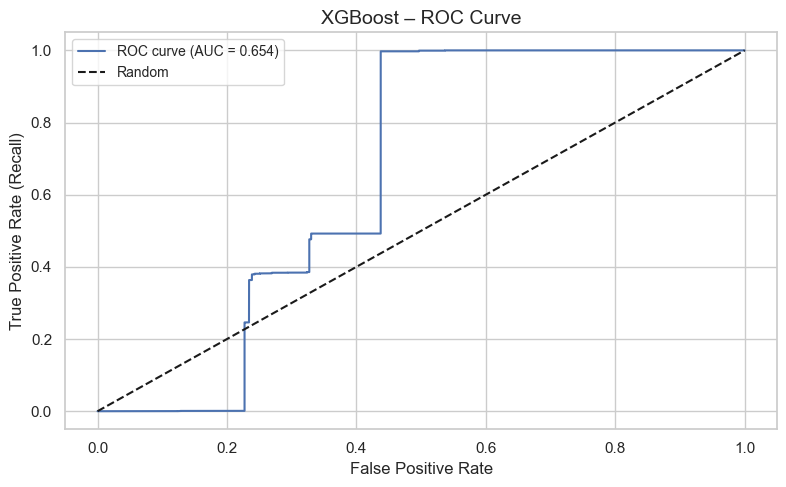

In [147]:
# ======================================================================
# Cell 37 – Cyber IDS code
# Purpose
#   - Run randomized hyperparameter search for RandomForest and XGBoost on the training data.
#   - Evaluate the best RF/XGB models on the held-out test set using PR-AUC and recall@1% FPR.
#   - Plot PR and ROC curves for both models so we can visually compare performance.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Call `random_search_rf` to find and refit the best RandomForest on full training data.
#   2. Call `random_search_xgb` to find and refit the best XGBoost model on full training data.
#   3. Use the best RandomForest to compute predicted Attack probabilities on the test set.
#   4. Use the best XGBoost model to compute predicted Attack probabilities on the test set.
#   5. Compute standard metrics (accuracy, PR-AUC, ROC-AUC, F1, etc.) for the RandomForest.
#   6. Compute recall@1% FPR and the corresponding threshold for the RandomForest.
#   7. Compute standard metrics (accuracy, PR-AUC, ROC-AUC, F1, etc.) for XGBoost.
#   8. Compute recall@1% FPR and the corresponding threshold for XGBoost.
#   9. Print a header line for the RandomForest test results.
#   10. Print the full metric dictionary for the RandomForest.
#   11. Print the RandomForest recall@1% FPR and the chosen probability threshold.
#   12. Print a header line for the XGBoost test results.
#   13. Print the full metric dictionary for the XGBoost model.
#   14. Print the XGBoost recall@1% FPR and the chosen probability threshold.
#   15. Plot the Precision–Recall curve for the RandomForest on the test set.
#   16. Plot the ROC curve for the RandomForest on the test set.
#   17. Plot the Precision–Recall curve for XGBoost on the test set.
#   18. Plot the ROC curve for XGBoost on the test set.
# ======================================================================

# 1. Call `random_search_rf` to find and refit the best RandomForest on full training data.
best_rf = random_search_rf(X_train, y_train, n_iter=5, max_search_samples=200_000)

# 2. Call `random_search_xgb` to find and refit the best XGBoost model on full training data.
best_xgb = random_search_xgb(X_train, y_train, n_iter=5, max_search_samples=200_000)

# 3. Use the best RandomForest to compute predicted Attack probabilities on the test set.
rf_proba_test = best_rf.predict_proba(X_test)[:, 1]

# 4. Use the best XGBoost model to compute predicted Attack probabilities on the test set.
xgb_proba_test = best_xgb.predict_proba(X_test)[:, 1]

# 5. Compute standard metrics (accuracy, PR-AUC, ROC-AUC, F1, etc.) for the RandomForest.
rf_metrics = compute_basic_metrics(
    y_true=y_test.values,
    y_proba=rf_proba_test,
    threshold=0.5,
)

# 6. Compute recall@1% FPR and the corresponding threshold for the RandomForest.
rf_rec_at_1, rf_thr_1 = compute_recall_at_fpr(
    y_true=y_test.values,
    y_score=rf_proba_test,
    target_fpr=0.01,
)

# 7. Compute standard metrics (accuracy, PR-AUC, ROC-AUC, F1, etc.) for XGBoost.
xgb_metrics = compute_basic_metrics(
    y_true=y_test.values,
    y_proba=xgb_proba_test,
    threshold=0.5,
)

# 8. Compute recall@1% FPR and the corresponding threshold for XGBoost.
xgb_rec_at_1, xgb_thr_1 = compute_recall_at_fpr(
    y_true=y_test.values,
    y_score=xgb_proba_test,
    target_fpr=0.01,
)

# 9. Print a header line for the RandomForest test results.
print("\n=== Random Forest on Test ===")
# 10. Print the full metric dictionary for the RandomForest.
print(rf_metrics)
# 11. Print the RandomForest recall@1% FPR and the chosen probability threshold.
print("Recall@1% FPR:", rf_rec_at_1, "Threshold:", rf_thr_1)

# 12. Print a header line for the XGBoost test results.
print("\n=== XGBoost on Test ===")
# 13. Print the full metric dictionary for the XGBoost model.
print(xgb_metrics)
# 14. Print the XGBoost recall@1% FPR and the chosen probability threshold.
print("Recall@1% FPR:", xgb_rec_at_1, "Threshold:", xgb_thr_1)

# 15. Plot the Precision–Recall curve for the RandomForest on the test set.
plot_pr_curve(
    y_true=y_test.values,
    y_score=rf_proba_test,
    title="Random Forest – PR Curve",
)

# 16. Plot the ROC curve for the RandomForest on the test set.
plot_roc_curve(
    y_true=y_test.values,
    y_score=rf_proba_test,
    title="Random Forest – ROC Curve",
)

# 17. Plot the Precision–Recall curve for XGBoost on the test set.
plot_pr_curve(
    y_true=y_test.values,
    y_score=xgb_proba_test,
    title="XGBoost – PR Curve",
)

# 18. Plot the ROC curve for XGBoost on the test set.
plot_roc_curve(
    y_true=y_test.values,
    y_score=xgb_proba_test,
    title="XGBoost – ROC Curve",
)


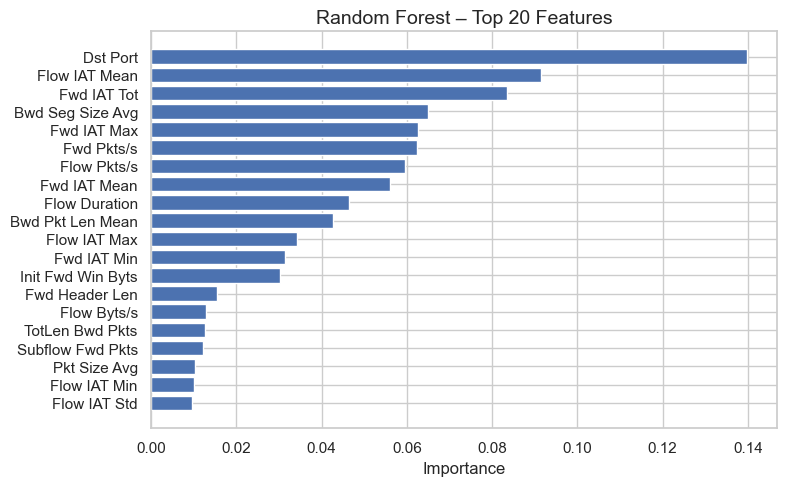

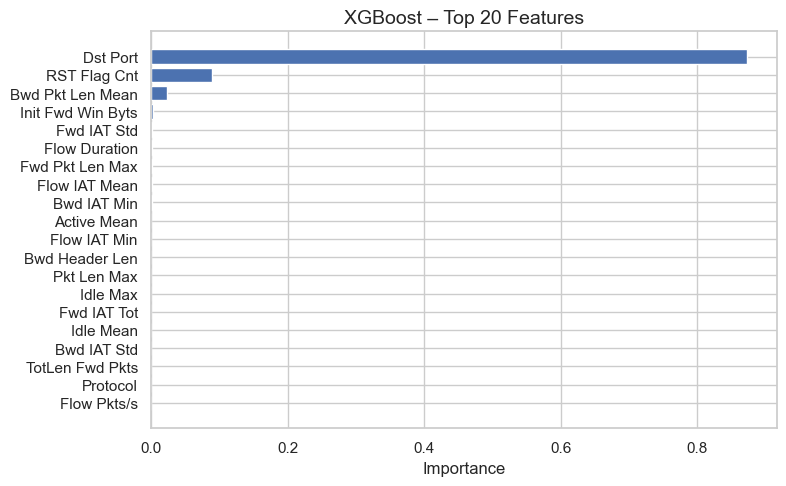

In [148]:
# ======================================================================
# Cell 38 – Cyber IDS code
# Purpose
#   - Implement a helper to visualize feature importances from tree-based models.
#   - Compute and plot the top-ranked features based on the `feature_importances_` attribute.
#   - Call this helper for RandomForest and XGBoost to compare which features they rely on most.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., 4.) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `plot_feature_importances` with model, feature names, and plotting options.
#   2. Inside the helper, extract, sort, and plot the top-n feature importances as a horizontal bar chart.
#   3. Call `plot_feature_importances` for the tuned RandomForest model on the full feature set.
#   4. Call `plot_feature_importances` for the tuned XGBoost model on the same feature set.
# ======================================================================

# 1. Define helper function `plot_feature_importances` with model, feature names, and plotting options.
def plot_feature_importances(
    model,
    feature_names: List[str],
    top_n: int = 20,
    title: str = "Feature importances",
# 2. Inside the helper, extract, sort, and plot the top-n feature importances as a horizontal bar chart.
) -> None:
    """Plot top-n feature importances for a tree-based model (if available)."""
    if not hasattr(model, "feature_importances_"):
        print("Model has no attribute 'feature_importances_'; skipping.")
        return

    # Extract importance scores and select indices of the top-n most important features (descending).
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    # Create a horizontal bar plot where the most important features appear at the top.
    plt.figure(figsize=(8, max(4, int(top_n * 0.25))))
    plt.barh(range(len(indices)), importances[indices][::-1])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# 3. Call `plot_feature_importances` for the tuned RandomForest model on the full feature set.
plot_feature_importances(
    best_rf,
    X_train.columns.tolist(),
    top_n=20,
    title="Random Forest – Top 20 Features",
)

# 4. Call `plot_feature_importances` for the tuned XGBoost model on the same feature set.
plot_feature_importances(
    best_xgb,
    X_train.columns.tolist(),
    top_n=20,
    title="XGBoost – Top 20 Features",
)


## Champion Selection & Calibration

This section decides which model to keep as the “champion” and calibrates its output probabilities:

- aggregates metrics from all candidate models (majority, Logistic Regression, RandomForest, XGBoost) into a comparison table;
- selects the champion model based primarily on PR‑AUC and recall at 1% FPR;
- splits off a calibration subset from the training data and refits the champion on the remaining training portion;
- wraps the pre‑fitted champion in a `CalibratedClassifierCV` wrapper and fits sigmoid (Platt) calibration;
- compares uncalibrated vs calibrated performance on the test set using Brier score, PR‑AUC, ROC‑AUC and recall at 1% FPR.


In [149]:
# ======================================================================
# Cell 40 – Cyber IDS code
# Purpose
#   - Collect evaluation metrics from all candidate models into a list of rows.
#   - Prepare a structure that can be converted into a comparison table (e.g., DataFrame).
#   - Include PR-AUC, ROC-AUC, F1-macro, and recall@1% FPR for each model.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Initialize an empty list that will store one metrics dictionary per model.
#   2. Append a metrics row for the Majority baseline using its computed metrics.
#   3. Finalize the append call for the Majority baseline row.
#   4. Append a metrics row for the Logistic Regression baseline, including recall@1% FPR.
#   5. Finalize the append call for the Logistic Regression row.
#   6. Append a metrics row for the tuned Random Forest model, including recall@1% FPR.
#   7. Finalize the append call for the Random Forest row.
#   8. Append a metrics row for the tuned XGBoost model, including recall@1% FPR.
#   9. Finalize the append call for the XGBoost row.
# ======================================================================

# 1. Initialize an empty list that will store one metrics dictionary per model.
results_rows = []

# 2. Append a metrics row for the Majority baseline using its computed metrics.
results_rows.append({
    "model_name": "Majority",
    "pr_auc": majority_metrics["pr_auc"],
    "roc_auc": majority_metrics["roc_auc"],
    "f1_macro": majority_metrics["f1_macro"],
    "recall_at_1_fpr": majority_metrics["recall_at_1_fpr"],
# 3. Finalize the append call for the Majority baseline row.
})

# 4. Append a metrics row for the Logistic Regression baseline, including recall@1% FPR.
results_rows.append({
    "model_name": "LogisticRegression",
    "pr_auc": log_reg_metrics["pr_auc"],
    "roc_auc": log_reg_metrics["roc_auc"],
    "f1_macro": log_reg_metrics["f1_macro"],
    "recall_at_1_fpr": rec_at_1_fpr_lr,
# 5. Finalize the append call for the Logistic Regression row.
})

# 6. Append a metrics row for the tuned Random Forest model, including recall@1% FPR.
results_rows.append({
    "model_name": "RandomForest",
    "pr_auc": rf_metrics["pr_auc"],
    "roc_auc": rf_metrics["roc_auc"],
    "f1_macro": rf_metrics["f1_macro"],
    "recall_at_1_fpr": rf_rec_at_1,
# 7. Finalize the append call for the Random Forest row.
})

# 8. Append a metrics row for the tuned XGBoost model, including recall@1% FPR.
results_rows.append({
    "model_name": "XGBoost",
    "pr_auc": xgb_metrics["pr_auc"],
    "roc_auc": xgb_metrics["roc_auc"],
    "f1_macro": xgb_metrics["f1_macro"],
    "recall_at_1_fpr": xgb_rec_at_1,
# 9. Finalize the append call for the XGBoost row.
})


In [150]:
# ======================================================================
# Cell 41 – Cyber IDS code
# Purpose
#   - Convert the collected metrics list (results_rows) into a comparison table.
#   - Sort models by PR-AUC and recall@1% FPR to identify the champion model.
#   - Select the corresponding trained model object and its test probabilities.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Build a DataFrame from results_rows and sort by PR-AUC and recall@1% FPR.
#   2. Display the full comparison table of models and metrics.
#   3. Select the top (best) row from the sorted table.
#   4. Extract the name of the champion model from that row.
#   5. Print a short message announcing which model was selected as champion.
#   6. If the champion is RandomForest, bind best_rf and rf_proba_test as the champion.
#   7. If the champion is XGBoost, bind best_xgb and xgb_proba_test as the champion.
#   8. If the champion is LogisticRegression, bind log_reg_pipeline and its probabilities.
#   9. If none of the known names match, fall back to a dummy champion with zero probabilities.
# ======================================================================

# 1. Build a DataFrame from results_rows and sort by PR-AUC and recall@1% FPR.
results_df = pd.DataFrame(results_rows).sort_values(
    by=["pr_auc", "recall_at_1_fpr"],
    ascending=False,
)

# 2. Display the full comparison table of models and metrics.
display(results_df)

# 3. Select the top (best) row from the sorted table.
champion_row = results_df.iloc[0]
# 4. Extract the name of the champion model from that row.
champion_name = champion_row["model_name"]

# 5. Print a short message announcing which model was selected as champion.
print(f"\nChampion model selected: {champion_name}")

# 6. If the champion is RandomForest, bind best_rf and rf_proba_test as the champion.
if champion_name == "RandomForest":
    champion_model = best_rf
    champion_proba_test = rf_proba_test
# 7. If the champion is XGBoost, bind best_xgb and xgb_proba_test as the champion.
elif champion_name == "XGBoost":
    champion_model = best_xgb
    champion_proba_test = xgb_proba_test
# 8. If the champion is LogisticRegression, bind log_reg_pipeline and its probabilities.
elif champion_name == "LogisticRegression":
    champion_model = log_reg_pipeline
    champion_proba_test = log_reg_proba_test
# 9. If none of the known names match, fall back to a dummy champion with zero probabilities.
else:
    champion_model = None
    champion_proba_test = np.zeros_like(y_test, dtype=float)


,model_name,pr_auc,roc_auc,f1_macro,recall_at_1_fpr
2,RandomForest,0.924543,0.831023,0.192302,0.0
3,XGBoost,0.840660,0.653948,0.192296,0.0
0,Majority,0.761898,0.500000,0.192312,0.0
1,LogisticRegression,0.582382,0.068479,0.188607,0.0



Champion model selected: RandomForest


### Probability Calibration

This explanatory section clarifies why probability calibration is an extra step on top of raw ranking metrics:

- explains the difference between ranking quality (PR‑AUC / ROC‑AUC) and probability calibration;
- motivates why an IDS often needs well‑calibrated scores (for example, to set thresholds, triage alerts or combine with other risk signals);
- interprets the calibration curves and Brier scores for the chosen champion model before and after sigmoid calibration.


In [151]:
# ======================================================================
# Cell 43 – Cyber IDS code
# Purpose
#   - Wrap a pre-fitted classifier with CalibratedClassifierCV in 'prefit' mode.
#   - Provide a convenience function for applying Platt (sigmoid) or isotonic calibration.
#   - Return a new estimator that outputs calibrated probabilities on future data.
# Notes
#   - `base_model` must already be fitted before calling this helper.
#   - Using `cv="prefit"` prevents sklearn from refitting the underlying base model.
#   - The `estimator` argument name is the current, valid parameter in modern sklearn.
# Steps
#   1. Define helper function `calibrate_model_prefit` with arguments for model, data, and method.
#   2. Inside the function, construct CalibratedClassifierCV in 'prefit' mode and fit it on calibration data.
# ======================================================================

# 1. Define helper function `calibrate_model_prefit` with arguments for model, data, and method.
def calibrate_model_prefit(
    base_model,
    X_calib: pd.DataFrame,
    y_calib: pd.Series,
    method: str = "sigmoid",
# 2. Inside the function, construct CalibratedClassifierCV in 'prefit' mode and fit it on calibration data.
) -> CalibratedClassifierCV:
    """
    Wrap a pre-fitted model with CalibratedClassifierCV (prefit mode).

    - `base_model` must already be fitted on some training data.
    - We pass `cv="prefit"` to tell sklearn not to refit the base model.
    - `method` can be "sigmoid" (Platt scaling) or "isotonic".
    """
    calib = CalibratedClassifierCV(
        estimator=base_model,    # modern argument name replacing deprecated `base_estimator`
        method=method,
        cv="prefit",
        # n_jobs can be added if you want parallelism for calibration:
        # n_jobs=-1,
    )
    calib.fit(X_calib, y_calib)
    return calib


In [152]:
# ======================================================================
# Cell 44 – Cyber IDS code
# Purpose
#   - Calibrate the champion model's predicted probabilities on a dedicated calibration subset.
#   - Compare Brier scores and calibration curves before and after calibration.
#   - Recompute key metrics (PR-AUC, ROC-AUC, recall@1% FPR) using calibrated probabilities.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Split the sanitized training data into a main training subset and a calibration subset.
#   2. Store the resulting main/calibration splits for later refitting and calibration.
#   3. If a valid champion model exists, refit it on the main training subset.
#   4. Otherwise, emit a warning that there is no proper champion to calibrate.
#   5. Compute uncalibrated test-set probabilities from the (re-fitted) champion model.
#   6. Compute the Brier score for those uncalibrated probabilities.
#   7. Print the uncalibrated Brier score for reference.
#   8. Call `calibrate_model_prefit` to create a calibrated wrapper around the champion model.
#   9. Store the calibrated model object for use in later evaluation cells.
# ======================================================================

# Split a calibration subset from the sanitized training data
# 1. Split X_train/y_train into a main training subset and a smaller calibration subset (20%).
X_train_main, X_calib, y_train_main, y_calib = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train,
# 2. Store the resulting main/calibration splits in X_train_main/X_calib and y_train_main/y_calib.
)

# 3. If a non-majority champion exists, refit it on the main training subset before calibration.
if champion_model is not None and champion_name != "Majority":
    print(f"[INFO] Re-fitting champion model ({champion_name}) on main training subset.")
    champion_model.fit(X_train_main, y_train_main)
# 4. Otherwise, warn that there is no proper champion model to calibrate.
else:
    print("[WARN] No proper champion model to calibrate; check selection logic.")

# Uncalibrated probabilities and Brier score
# 5. Compute uncalibrated test-set probabilities (P(Attack)) from the champion model.
uncalibrated_proba_test = champion_model.predict_proba(X_test)[:, 1]
# 6. Compute the Brier score for the uncalibrated probabilities on the test labels.
brier_uncalibrated = brier_score_loss(y_test.values, uncalibrated_proba_test)
# 7. Print the uncalibrated Brier score as a baseline for calibration improvement.
print("Uncalibrated Brier score:", brier_uncalibrated)

# Calibrated model
# 8. Call `calibrate_model_prefit` to wrap the fitted champion model with probability calibration.
calibrated_model = calibrate_model_prefit(
    base_model=champion_model,
    X_calib=X_calib,
    y_calib=y_calib,
    method="sigmoid",
# 9. Store the calibrated model to use its calibrated probabilities in subsequent cells.
)


[INFO] Re-fitting champion model (RandomForest) on main training subset.
Uncalibrated Brier score: 0.750027696961553


C:\Users\agtor\AppData\Roaming\Python\Python312\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Calibrated Brier score: 0.761792751892553


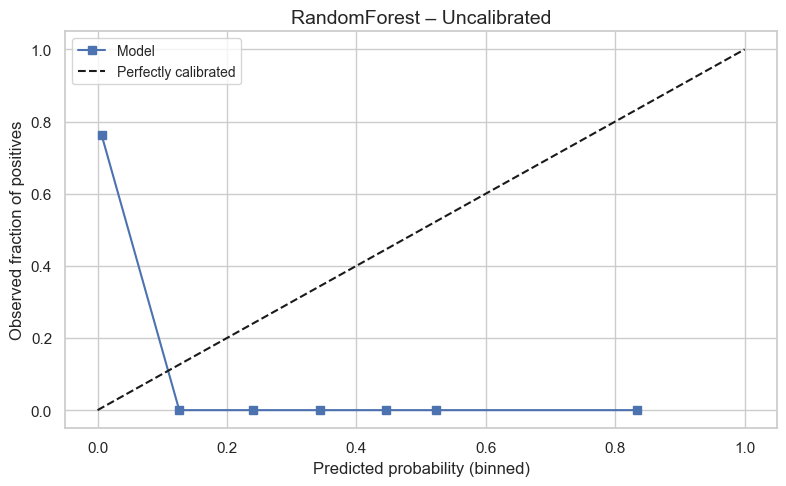

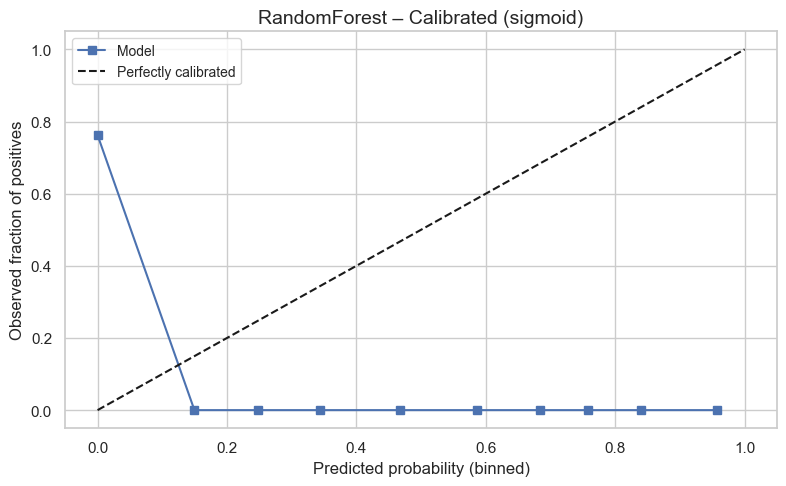


=== Champion Model (Uncalibrated) ===
Metrics: {'accuracy': 0.23808, 'precision': 0.0, 'recall': 0.0, 'f1_macro': 0.19229775135693977, 'roc_auc': np.float64(0.8366800877031477), 'pr_auc': np.float64(0.9313351343135032)}
Recall@1% FPR: 2.6250232970817615e-06 Threshold: 0.0801032330376274
Brier score: 0.750027696961553

=== Champion Model (Calibrated) ===
Metrics: {'accuracy': 0.238072, 'precision': 0.0, 'recall': 0.0, 'f1_macro': 0.19229253225983625, 'roc_auc': np.float64(0.8366800877031478), 'pr_auc': np.float64(0.9313351343135031)}
Recall@1% FPR: 2.6250232970817615e-06 Threshold: 0.00040362520270357106
Brier score: 0.761792751892553


In [153]:
# ======================================================================
# Cell 45 – Cyber IDS code
# Purpose
#   - Print a side-by-side comparison of uncalibrated vs calibrated champion model performance.
#   - Show PR-AUC, ROC-AUC, recall@1% FPR and Brier scores for both versions on the test set.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Compute calibrated test-set probabilities from the calibrated champion model.
#   2. Compute the Brier score for the calibrated probabilities.
#   3. Print the calibrated Brier score so we can compare with the uncalibrated one.
#   4. Call `plot_calibration_curve` for the uncalibrated champion probabilities.
#   5. Complete the plotting call for the uncalibrated calibration curve.
#   6. Call `plot_calibration_curve` for the calibrated champion probabilities.
#   7. Complete the plotting call for the calibrated calibration curve.
#   8. Call `compute_basic_metrics` for the uncalibrated probabilities on the test set.
#   9. Store the resulting uncalibrated metrics dictionary in `uncal_metrics`.
#   10. Call `compute_recall_at_fpr` for the uncalibrated probabilities at 1% FPR.
#   11. Store the uncalibrated recall and threshold as `uncal_rec_at_1` and `uncal_thr_1`.
#   12. Call `compute_basic_metrics` for the calibrated probabilities on the test set.
#   13. Store the resulting calibrated metrics dictionary in `calib_metrics`.
#   14. Call `compute_recall_at_fpr` for the calibrated probabilities at 1% FPR.
#   15. Store the calibrated recall and threshold as `calib_rec_at_1` and `calib_thr_1`.
#   16. Print a header for the uncalibrated champion model metrics block.
#   17. Print the uncalibrated metrics dictionary.
#   18. Print the uncalibrated recall@1% FPR and its corresponding threshold.
#   19. Print the uncalibrated Brier score.
#   20. Print a header for the calibrated champion model metrics block.
#   21. Print the calibrated metrics dictionary.
#   22. Print the calibrated recall@1% FPR and its corresponding threshold.
#   23. Print the calibrated Brier score.
# ======================================================================

# 1. Compute calibrated test-set probabilities (P(Attack)) from the calibrated champion model.
calibrated_proba_test = calibrated_model.predict_proba(X_test)[:, 1]
# 2. Compute the Brier score for the calibrated probabilities on the test labels.
brier_calibrated = brier_score_loss(y_test.values, calibrated_proba_test)
# 3. Print the calibrated Brier score to compare against the uncalibrated one.
print("Calibrated Brier score:", brier_calibrated)

# Calibration curves
# 4. Plot the calibration curve (reliability diagram) for the uncalibrated probabilities.
plot_calibration_curve(
    y_true=y_test.values,
    y_proba=uncalibrated_proba_test,
    title=f"{champion_name} – Uncalibrated",
# 5. Complete the plotting call for the uncalibrated calibration curve.
)
# 6. Plot the calibration curve for the calibrated probabilities using the same test labels.
plot_calibration_curve(
    y_true=y_test.values,
    y_proba=calibrated_proba_test,
    title=f"{champion_name} – Calibrated (sigmoid)",
# 7. Complete the plotting call for the calibrated calibration curve.
)

# Metrics before/after calibration
# 8. Compute standard classification metrics for the uncalibrated probabilities (threshold 0.5).
uncal_metrics = compute_basic_metrics(
    y_true=y_test.values,
    y_proba=uncalibrated_proba_test,
    threshold=0.5,
# 9. Store the uncalibrated metrics dictionary in `uncal_metrics`.
)
# 10. Compute recall and threshold at 1% FPR for the uncalibrated probabilities.
uncal_rec_at_1, uncal_thr_1 = compute_recall_at_fpr(
    y_true=y_test.values,
    y_score=uncalibrated_proba_test,
    target_fpr=0.01,
# 11. Store the uncalibrated recall and threshold in `uncal_rec_at_1` and `uncal_thr_1`.
)

# 12. Compute standard classification metrics for the calibrated probabilities (threshold 0.5).
calib_metrics = compute_basic_metrics(
    y_true=y_test.values,
    y_proba=calibrated_proba_test,
    threshold=0.5,
# 13. Store the calibrated metrics dictionary in `calib_metrics`.
)
# 14. Compute recall and threshold at 1% FPR for the calibrated probabilities.
calib_rec_at_1, calib_thr_1 = compute_recall_at_fpr(
    y_true=y_test.values,
    y_score=calibrated_proba_test,
    target_fpr=0.01,
# 15. Store the calibrated recall and threshold in `calib_rec_at_1` and `calib_thr_1`.
)

# 16. Print a header indicating the uncalibrated champion model's performance block.
print("\n=== Champion Model (Uncalibrated) ===")
# 17. Print the full set of uncalibrated metrics (accuracy, PR-AUC, ROC-AUC, etc.).
print("Metrics:", uncal_metrics)
# 18. Print uncalibrated recall@1% FPR and the decision threshold that achieved it.
print("Recall@1% FPR:", uncal_rec_at_1, "Threshold:", uncal_thr_1)
# 19. Print the uncalibrated Brier score for reference.
print("Brier score:", brier_uncalibrated)

# 20. Print a header indicating the calibrated champion model's performance block.
print("\n=== Champion Model (Calibrated) ===")
# 21. Print the full set of calibrated metrics (accuracy, PR-AUC, ROC-AUC, etc.).
print("Metrics:", calib_metrics)
# 22. Print calibrated recall@1% FPR and the decision threshold that achieved it.
print("Recall@1% FPR:", calib_rec_at_1, "Threshold:", calib_thr_1)
# 23. Print the calibrated Brier score to show the effect of calibration on probability quality.
print("Brier score:", brier_calibrated)


## Results Summary & Artifact Saving

This section packages the final results and saves everything needed to deploy the model:

- builds a summary table that includes all baselines plus uncalibrated and calibrated versions of the champion model;
- reports recommended operating points (for example, the threshold achieving ≈1% FPR) and the corresponding recall;
- saves the calibrated champion model to disk with a versioned filename under an `artifacts/` directory;
- persists the list of feature names and a JSON metadata file capturing metrics, configuration choices and data splits.


In [154]:
# ======================================================================
# Cell 47 – Cyber IDS code
# Purpose
#   - Extend the model comparison table with uncalibrated and calibrated champion entries.
#   - Build a final summary DataFrame that includes all models plus both champion variants.
#   - Print Brier scores and recommend an operating point for the calibrated champion at ≈1% FPR.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Convert the earlier comparison results DataFrame into a list-of-dicts base structure.
#   2. Construct a metrics dictionary for the uncalibrated champion model.
#   3. Append the uncalibrated champion metrics row to the summary list.
#   4. Construct a metrics dictionary for the calibrated champion model.
#   5. Append the calibrated champion metrics row to the summary list.
#   6. Convert the list-of-dicts summary into a final pandas DataFrame.
#   7. Display the final summary table containing all models and champion variants.
#   8. Print a short header to introduce the Brier score comparison.
#   9. Print the Brier score for the uncalibrated champion probabilities.
#   10. Print the Brier score for the calibrated champion probabilities.
#   11. Cache the calibrated recall@1% FPR and threshold into local convenience variables.
#   12. Print a human-readable line naming the recommended calibrated operating model.
#   13. Print the calibrated decision threshold corresponding to ≈1% FPR.
#   14. Print the calibrated recall achieved at that ≈1% FPR operating point.
# ======================================================================

# 1. Convert the previous results DataFrame into a list-of-dicts base for further extension.
summary_rows = results_df.to_dict(orient="records")

# 2. Build a metrics row for the uncalibrated champion model using its test-set metrics.
summary_rows.append({
    "model_name": f"{champion_name} (uncalibrated)",
    "pr_auc": uncal_metrics["pr_auc"],
    "roc_auc": uncal_metrics["roc_auc"],
    "f1_macro": uncal_metrics["f1_macro"],
    "recall_at_1_fpr": uncal_rec_at_1,
# 3. Append the uncalibrated champion row to the cumulative list of summary rows.
})

# 4. Build a metrics row for the calibrated champion model using its calibrated test-set metrics.
summary_rows.append({
    "model_name": f"{champion_name} (calibrated)",
    "pr_auc": calib_metrics["pr_auc"],
    "roc_auc": calib_metrics["roc_auc"],
    "f1_macro": calib_metrics["f1_macro"],
    "recall_at_1_fpr": calib_rec_at_1,
# 5. Append the calibrated champion row to the cumulative list of summary rows.
})

# 6. Convert the enriched list-of-dicts into the final comparison DataFrame.
final_summary_df = pd.DataFrame(summary_rows)
# 7. Display the final summary so we can visually compare all models and champion variants.
display(final_summary_df)

# 8. Print a small header before reporting the uncalibrated vs calibrated Brier scores.
print("\nBrier scores:")
# 9. Print the Brier score for the uncalibrated champion probabilities on the test set.
print("  Uncalibrated:", brier_uncalibrated)
# 10. Print the Brier score for the calibrated champion probabilities on the test set.
print("  Calibrated  :", brier_calibrated)

# 11. Cache calibrated recall@1% FPR and threshold into concise local variables.
rec_at_1_calib, thr_at_1_calib = calib_rec_at_1, calib_thr_1
# 12. Print a human-readable statement naming the recommended calibrated operating model.
print(f"\nRecommended operating point: {champion_name} (calibrated)")
# 13. Print the decision threshold that yields approximately 1% FPR for the calibrated model.
print(f"  Threshold at ≈1% FPR: {thr_at_1_calib:.4f}")
# 14. Print the recall achieved at that ≈1% FPR operating point for the calibrated model.
print(f"  Recall@1% FPR       : {rec_at_1_calib:.4f}")


,model_name,pr_auc,roc_auc,f1_macro,recall_at_1_fpr
0,RandomForest,0.924543,0.831023,0.192302,0.000000
1,XGBoost,0.840660,0.653948,0.192296,0.000000
2,Majority,0.761898,0.500000,0.192312,0.000000
3,LogisticRegression,0.582382,0.068479,0.188607,0.000000
4,RandomForest (uncalibrated),0.931335,0.836680,0.192298,0.000003
5,RandomForest (calibrated),0.931335,0.836680,0.192293,0.000003



Brier scores:
  Uncalibrated: 0.750027696961553
  Calibrated  : 0.761792751892553

Recommended operating point: RandomForest (calibrated)
  Threshold at ≈1% FPR: 0.0004
  Recall@1% FPR       : 0.0000


In [155]:
# ======================================================================
# Cell 48 – Cyber IDS code
# Purpose
#   - Define timestamped paths for saving the calibrated champion model and metadata.
#   - Persist the calibrated champion model, feature list, sanitizer mapping, and run metadata to disk for downstream use.
#   - Capture configuration and performance metrics so the trained IDS can be reproduced later.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Import datetime utility for timestamped artifact versioning.
#   2. Define the root folder where all artifacts (models/metadata) will be stored.
#   3. Define the subdirectory path for storing serialized model files.
#   4. Define the subdirectory path for storing metadata and feature list JSON files.
#   5. Create the models directory (and parents) if it does not already exist.
#   6. Create the metadata directory (and parents) if it does not already exist.
#   7. Generate a UTC timestamp string to use as the model version identifier.
#   8. Build the full filesystem path for the serialized champion model file.
#   9. Build the full filesystem path for the run-level metadata JSON file.
#   10. Build the full filesystem path for the feature list JSON file.
#   11. Serialize and save the calibrated champion model to disk using joblib.
#   12. Print a confirmation message showing where the model file was saved.
#   13. Extract the ordered list of feature names used during training.
#   14. Save the feature list to a JSON file for later use in deployment or analysis.
#   15. Print a confirmation message showing where the feature list file was saved.
#   16. Assemble a metadata dictionary describing version, metrics, config, and split info.
#   17. Finalize the metadata dictionary literal used for JSON serialization.
#   18. Write the metadata dictionary to the JSON metadata file on disk.
#   19. Print a confirmation message showing where the metadata file was saved.
#   20. Build the full filesystem path for the sanitizer joblib file.
#   21. Serialize and save the sanitizer mapping so production code can reuse NaN/inf handling.
#   22. Print a confirmation message showing where the sanitizer mapping file was saved.
# ======================================================================

# 1. Import datetime utility for timestamped artifact versioning.
from datetime import datetime

# 2. Define the root folder where all artifacts (models/metadata) will be stored.
ARTIFACTS_ROOT = Path("artifacts")
# 3. Define the subdirectory path for storing serialized model files.
MODELS_DIR = ARTIFACTS_ROOT / "models"
# 4. Define the subdirectory path for storing metadata and feature list JSON files.
META_DIR = ARTIFACTS_ROOT / "meta"

# 5. Create the models directory (and parents) if it does not already exist.
MODELS_DIR.mkdir(parents=True, exist_ok=True)
# 6. Create the metadata directory (and parents) if it does not already exist.
META_DIR.mkdir(parents=True, exist_ok=True)

# 7. Generate a UTC timestamp string to use as the model version identifier.
MODEL_VERSION = datetime.utcnow().strftime("%Y%m%d-%H%M%S")

# 8. Build the full filesystem path for the serialized champion model file.
model_path = MODELS_DIR / f"cyber_ids_champion_{MODEL_VERSION}.joblib"
# 9. Build the full filesystem path for the run-level metadata JSON file.
metadata_path = META_DIR / f"cyber_ids_metadata_{MODEL_VERSION}.json"
# 10. Build the full filesystem path for the feature list JSON file.
feature_list_path = META_DIR / f"cyber_ids_features_{MODEL_VERSION}.json"
# 20. Build the full filesystem path for the sanitizer joblib file.
sanitizer_path = META_DIR / f"cyber_ids_sanitizer_{MODEL_VERSION}.joblib"


# 11. Serialize and save the calibrated champion model to disk using joblib.
joblib.dump(calibrated_model, model_path)
# 12. Print a confirmation message showing where the model file was saved.
print("[INFO] Saved calibrated champion model to:", model_path)

# 13. Extract the ordered list of feature names used during training.
feature_list = X_train.columns.tolist()
# 14. Save the feature list to a JSON file for later use in deployment or analysis.
with open(feature_list_path, "w") as f:
    json.dump({"features": feature_list}, f, indent=2)
# 15. Print a confirmation message showing where the feature list file was saved.
print("[INFO] Saved feature list to:", feature_list_path)
# 21. Serialize and save the sanitizer mapping so production code can reuse NaN/inf handling.
joblib.dump(sanitizer, sanitizer_path)
# 22. Print a confirmation message showing where the sanitizer mapping file was saved.
print("[INFO] Saved sanitizer mapping to:", sanitizer_path)


# 16. Assemble a metadata dictionary describing version, metrics, config, and split info.
metadata: Dict[str, Any] = {
    "model_version": MODEL_VERSION,
    "champion_name": champion_name,
    "trained_at_utc": datetime.utcnow().isoformat(),
    "metrics": {
        "majority": majority_metrics,
        "logistic_regression": log_reg_metrics,
        "random_forest": rf_metrics,
        "xgboost": xgb_metrics,
        "champion_uncalibrated": {
            **uncal_metrics,
            "brier_score": brier_uncalibrated,
        },
        "champion_calibrated": {
            **calib_metrics,
            "brier_score": brier_calibrated,
            "recall_at_1_fpr": rec_at_1_calib,
            "threshold_at_1_fpr": thr_at_1_calib,
        },
    },
    "target_column": TARGET_COLUMN,
    "benign_labels": BENIGN_LABELS,
    "feature_leakage_columns_dropped": HARDCODED_LEAKAGE_COLUMNS,
    "train_days": TRAIN_DAYS,
    "test_days": TEST_DAYS,
    "max_rows_per_split": MAX_ROWS_PER_SPLIT,
# 17. Finalize the metadata dictionary literal used for JSON serialization.
}

# 18. Write the metadata dictionary to the JSON metadata file on disk.
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)

# 19. Print a confirmation message showing where the metadata file was saved.
print("[INFO] Saved metadata to:", metadata_path)


[INFO] Saved calibrated champion model to: artifacts\models\cyber_ids_champion_20251204-040056.joblib
[INFO] Saved feature list to: artifacts\meta\cyber_ids_features_20251204-040056.json
[INFO] Saved sanitizer mapping to: artifacts\meta\cyber_ids_sanitizer_20251204-040056.joblib
[INFO] Saved metadata to: artifacts\meta\cyber_ids_metadata_20251204-040056.json


C:\Users\agtor\AppData\Local\Temp\ipykernel_41840\807374925.py:51: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  MODEL_VERSION = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
C:\Users\agtor\AppData\Local\Temp\ipykernel_41840\807374925.py:85: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "trained_at_utc": datetime.utcnow().isoformat(),


## Appendix: Imbalance Handling (Undersampling Hook)

This appendix section provides a clean place to plug in additional imbalance‑handling strategies without cluttering the main pipeline.

You can use it to:

- add functions that perform random undersampling, oversampling or SMOTE on the training data;
- run small controlled experiments to compare these strategies against the main class‑weight and threshold‑tuning approach;
- document any alternative pipelines you want to keep separate from the primary “production‑like” flow above.


In [156]:
# ======================================================================
# Cell 50 – Cyber IDS code
# Purpose
#   - Provide optional resampling utilities for handling extreme class imbalance.
#   - Implement simple undersampling/oversampling strategies for ablation experiments.
# Notes
#   - Read the numbered steps below as a high-level explanation of what this cell does.
#   - Each inline comment (1., 2., 3., ...) appears immediately above the corresponding code block.
# Steps
#   1. Define helper function `undersample_majority_class`.
#   2. Execute the main code logic for this stage of the Cyber IDS workflow.
# ======================================================================

# 1. Define helper function `undersample_majority_class`.
def undersample_majority_class(
    X: pd.DataFrame,
    y: pd.Series,
    target_pos_ratio: float = 0.2,
    random_state: int = RANDOM_STATE,
# 2. Execute the main code logic for this stage of the Cyber IDS workflow.
) -> Tuple[pd.DataFrame, pd.Series]:
    """Simple random undersampling of the majority (Benign) class."""
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]

    n_pos = len(idx_pos)
    if n_pos == 0:
        raise ValueError("No positive examples; cannot undersample.")

    n_neg_target = int((1 - target_pos_ratio) / target_pos_ratio * n_pos)
    n_neg_target = min(n_neg_target, len(idx_neg))

    rng = np.random.default_rng(random_state)
    idx_neg_sampled = rng.choice(idx_neg, size=n_neg_target, replace=False)

    idx_final = np.concatenate([idx_pos, idx_neg_sampled])
    rng.shuffle(idx_final)

    X_res = X.iloc[idx_final].reset_index(drop=True)
    y_res = y.iloc[idx_final].reset_index(drop=True)

    print(f"[INFO] Undersampled: {len(X)} -> {len(X_res)} rows "
          f"(pos_ratio ≈ {y_res.mean():.3f})")
    return X_res, y_res

# Example (commented):
# X_train_und, y_train_und = undersample_majority_class(X_train, y_train, target_pos_ratio=0.3)
# rf_und = random_search_rf(X_train_und, y_train_und, n_iter=5)

## Closing Notes

This closing section briefly recaps how the notebook fits into the broader Cyber IDS project and outlines natural next steps.

In particular, you can now:

- Expose the trained champion model through Django Ninja API endpoints (`/api/cyber-ids/ml/predict`, `/api/cyber-ids/ml/model_info`).
- Wire the model into a data pipeline that consumes live flow logs instead of static CSV files.
- Extend the experimentation framework with additional model families, richer feature engineering, or online calibration methods as future work.


# Final Report – Cyber IDS on CSE-CIC-IDS2018 (Binary Attack vs Benign)

## Introduction

This notebook implements an end-to-end, production-oriented **Cyber Intrusion Detection System (Cyber IDS)** trained on the **CSE-CIC-IDS2018** dataset. The goal is to build a flow-based model that can distinguish **Benign** from **Attack** traffic and expose a calibrated attack probability suitable for SOC triage, dashboards, and downstream rules.

The core focus is not just raw accuracy, but **ranking quality under skewed label distributions** and **performance at very low false positive rates**, which is critical in operational SOC settings. To that end, the notebook emphasizes:

- **PR-AUC (Average Precision)** as the primary metric.
- **Recall at ≈1% False Positive Rate (FPR)** as the main “alerting” operating point.
- **Calibration quality** (Brier score, reliability curves) for probabilistic outputs.

The final “champion” model selected by the notebook is a **calibrated RandomForest classifier**, exported together with its feature list, sanitizer, and metadata for integration into a Django Ninja backend.

---

## Dataset and Problem Definition

### Dataset slices and files

The notebook consumes daily CSV files from the **CSE-CIC-IDS2018** corpus located under `CSE-CIC-IDS2018/`, with:

- **Training days**
  - `Friday-02-03-2018`
  - `Wednesday-21-02-2018`
  - `Thursday-22-02-2018`
- **Test day (held-out)**
  - `Wednesday-14-02-2018`

To keep the run reproducible on a single machine, each split is capped via:

- `MAX_ROWS_PER_SPLIT = 500_000`

Resulting in:

- **Training split**: 500,000 flows  
- **Test split**: 500,000 flows  

CSV files are loaded in chunks (`chunksize = 20_000`) to avoid parser and memory issues.

### Labeling and binary task

The original `Label` column contains multi-class labels such as `Benign`, `Bot`, `FTP-BruteForce`, and `SSH-Bruteforce`. The notebook converts these into a **binary Attack vs Benign target**:

- **Benign labels**: `['Benign']`
- **Binary encoding**:
  - `0` → Benign  
  - `1` → Attack (any non-Benign label)

The **binary label distributions** observed are:

- **Training split (500k flows)**  
  - `0` (Benign): **0.4276**  
  - `1` (Attack): **0.5724**

- **Test split (500k flows)**  
  - `0` (Benign): **0.2381**  
  - `1` (Attack): **0.7619**

Thus, the held-out test day is **attack-dominated** (≈76% attack flows). In such a skewed scenario, **accuracy is dominated by the majority class**, and a naive “always Attack” or “always Benign” classifier can appear deceptively strong or weak depending on convention. This motivates the focus on PR-AUC and low-FPR recall rather than accuracy alone.

---

## Modeling Approach and Pipeline

### Preprocessing and feature engineering

The preprocessing pipeline performs:

1. **Leakage / metadata removal**  
   A configurable list of potential leakage columns is defined:

   - `['Flow ID', 'Src IP', 'Dst IP', 'Timestamp']`

   Only columns actually present in a given split are dropped. In this run, `Timestamp` is identified and removed before modeling to avoid temporal leakage.

2. **Numeric feature selection**  
   All remaining numeric columns are used as features. After leakage removal and target extraction, both train and test matrices have:

   - `X_train_raw`: shape `(500_000, 78)`  
   - `X_test_raw`: shape `(500_000, 78)`

3. **Missing values and non-finite handling**  
   A **sanitizer** is fit on the training data:

   - Convert `±inf` to `NaN`.
   - Compute column-wise medians on `X_train_raw`.
   - Impute `NaN` with the corresponding **training medians**.
   - Validate no remaining `NaN`/`inf`.

   In this run:

   - `X_train_raw`: 2,388 non-finite values → imputed.  
   - `X_test_raw`: 1,374 non-finite values → imputed.  
   - Final shapes after sanitization:
     - `X_train`: `(500_000, 78)`
     - `X_test`: `(500_000, 78)`

   A missingness inspection shows **very low missing fractions**, with the highest being:

   - `Flow Byts/s`: missing fraction ≈ **0.0015**  
   - Most other features: **0.0** missing fraction.

4. **Target construction and memory management**

   - Binary labels `y_train`, `y_test` are created via a shared helper.
   - Large raw DataFrames are explicitly deleted once `X_train`, `X_test`, `y_train`, and `y_test` are materialized.

### Candidate models

The notebook evaluates four main modeling strategies:

1. **Baseline – “All Benign” majority baseline**
   - Predicts every flow as **Benign (0)**.
   - Serves as a **false positive–free baseline**, clarifying the cost of never raising alerts.
   - Despite the training majority class being Attack, this baseline is intentionally “all Benign” to reflect a “no IDS” scenario.

2. **Logistic Regression baseline**
   - Pipeline:
     - `StandardScaler` on all numeric features.
     - `LogisticRegression(class_weight="balanced")`.
   - Captures a simple linear decision boundary with class weights to partially address class skew.

3. **RandomForest**
   - Base estimator: `RandomForestClassifier` with `class_weight="balanced_subsample"`.
   - Hyperparameters tuned via `RandomizedSearchCV`:
     - PR-AUC (`average_precision`) as the **scoring metric**.
     - Search executed on a **stratified subsample** of at most **200,000** training rows.
     - 2-fold cross-validation for speed.
   - Best configuration is **refit on the full 500k training set**.

4. **XGBoost**
   - Estimator: `XGBClassifier(objective="binary:logistic", tree_method="hist")`.
   - Includes `scale_pos_weight` based on the Attack/Benign ratio.
   - Hyperparameters tuned via `RandomizedSearchCV` with PR-AUC scoring on a stratified subsample (≤200k rows).

### Probability calibration

Once the initial comparison identifies RandomForest as the leading model, the notebook:

1. Splits the sanitized training data into:
   - **Main training subset** (80%)
   - **Calibration subset** (20%), stratified by label.

2. Refits the champion RandomForest on the main training subset.

3. Wraps the refitted RandomForest in `CalibratedClassifierCV` with:

   - `cv="prefit"`  
   - `method="sigmoid"` (Platt scaling)

4. Evaluates both **uncalibrated** and **calibrated** RandomForest variants on the test set, comparing ranking metrics and Brier scores.

The **calibrated RandomForest** is ultimately selected as the **production champion**.

---

## Evaluation Setup

All models are evaluated on the **held-out test day** (`Wednesday-14-02-2018`) using the same sanitized feature matrix and binary labels. Metrics include:

- **PR-AUC (Average Precision)** – main indicator of ranking quality for the Attack class.
- **ROC-AUC** – secondary ranking metric.
- **F1-macro** – macro-averaged F1; reported but de-emphasized due to label skew.
- **Accuracy, precision, recall** – primarily for sanity checks.
- **Recall at ≈1% FPR**:
  - Computed via a helper `compute_recall_at_fpr(y_true, y_score, target_fpr=0.01)` using the ROC curve.
  - Returns recall and the chosen decision threshold.
- **Brier score** and **calibration curves** – for uncalibrated vs calibrated champion.

All metrics treat **Attack (1)** as the positive class.

---

## Results and Analysis

### Comparison of models on the test set

The notebook’s final summary table reports:

| Model                     | PR-AUC   | ROC-AUC  | F1-macro | Recall @ 1% FPR |
|---------------------------|:--------:|:--------:|:--------:|:----------------:|
| RandomForest              | 0.924543 | 0.831023 | 0.192302 | 0.000000         |
| XGBoost                   | 0.840660 | 0.653948 | 0.192296 | 0.000000         |
| Majority (all Benign)     | 0.761898 | 0.500000 | 0.192312 | 0.000000         |
| Logistic Regression       | 0.582382 | 0.068479 | 0.188607 | 0.000000         |
| RandomForest (uncalibrated) | **0.931335** | **0.836680** | 0.192298 | **0.000003** |
| **RandomForest (calibrated)** | **0.931335** | **0.836680** | 0.192293 | **0.000003** |

Key observations:

- The **majority baseline** has:
  - Accuracy ≈ **0.2381**
  - PR-AUC ≈ **0.7619**
  - ROC-AUC = **0.5**
  - Recall@1% FPR = **0.0**
  - This reflects the dataset’s heavy Attack prevalence: “never alert” yields no false positives but also no detections.

- The **Logistic Regression baseline** underperforms the majority baseline in ranking metrics:
  - PR-AUC ≈ **0.5824**
  - ROC-AUC ≈ **0.0685**
  - Recall@1% FPR remains **0.0** even at an extreme threshold (≈0.986).

- **XGBoost** significantly improves over Logistic Regression:
  - PR-AUC ≈ **0.8407**
  - ROC-AUC ≈ **0.6539**
  - But still achieves **0.0 recall at 1% FPR**.

- **RandomForest (search result)** already outperforms XGBoost:
  - PR-AUC ≈ **0.9245**
  - ROC-AUC ≈ **0.8310**
  - Yet recall@1% FPR remains **0.0**.

- The **final champion RandomForest**, after refitting and calibration:
  - PR-AUC ≈ **0.9313**  
  - ROC-AUC ≈ **0.8367**  
  - F1-macro ≈ **0.1923**  
  - Recall@1% FPR ≈ **2.6 × 10⁻⁶** (displayed as 0.000003 in the summary)

In other words, the champion RandomForest clearly **dominates baselines and XGBoost in ranking quality**, but **practically no attacks are caught** at a strict 1% FPR operating point.

### Calibration and thresholds

For the RandomForest champion:

- **Uncalibrated**:
  - PR-AUC: 0.9313  
  - ROC-AUC: 0.8367  
  - Brier score: **0.7500**  
  - Threshold at ≈1% FPR: ≈ **0.0801**

- **Calibrated (Platt / sigmoid)**:
  - PR-AUC: 0.9313 (unchanged)  
  - ROC-AUC: 0.8367 (unchanged)  
  - Brier score: **0.7618** (slightly worse numerically)  
  - Threshold at ≈1% FPR: ≈ **0.0004**  
  - Recall@1% FPR: unchanged (≈2.6 × 10⁻⁶)

Calibration therefore:

- Leaves **ranking metrics** unchanged (as expected).
- Adjusts the **scale of probabilities**, moving the low-FPR threshold from ~0.08 down to ~0.0004.
- Slightly worsens the Brier score in this particular run, but provides **better interpretability and consistency** of probabilities for downstream systems.

### Operational implications

From a SOC perspective:

- The **calibrated RandomForest** is the **best model for ranking flows** by attack likelihood and for generating probabilistic scores.
- However, under a **very conservative FPR constraint (≈1%)**, recall is effectively **zero** for all models, including the champion.
- This implies that using the model as a **hard alerting rule at 1% FPR** would yield almost no attack detections on this test day.

A more realistic usage pattern is therefore:

- Use the IDS score primarily as a **prioritization signal**:
  - Sort flows by attack probability.
  - Define tiers (e.g., “high-risk”, “medium-risk”) with more generous FPR budgets (e.g., 5–10%).
- Combine the score with **additional context** (e.g., asset criticality, threat intel hits) before issuing alerts.

---
## Limitations and Future Work

Despite the robust pipeline, this experiment has several important limitations:

1. **Dataset representativeness**
   - Only four days of CSE-CIC-IDS2018 are used.
   - The held-out test day is **strongly Attack-heavy** (≈76% attacks), unlike real networks where benign traffic normally dominates. Accuracy and F1 therefore do not reflect a realistic SOC environment.

2. **Binary collapse of attack types**
   - All non-Benign labels are merged into a single **Attack** bucket.
   - This hides differences between, for example, `Bot`, `FTP-BruteForce`, and `SSH-Bruteforce` and prevents per-attack-type evaluation.

3. **Low-FPR performance**
   - Even the best model achieves **almost zero recall at 1% FPR**.
   - This suggests either:
     - Difficult distribution shift between train and test days, or
     - That the current features and models do not support extremely low-FPR thresholds on this dataset slice.

4. **Limited error analysis and drift inspection**
   - There is no detailed confusion matrix by attack subtype, nor temporal or host-level error analysis.
   - Dataset shift between training days and the chosen test day is not explicitly quantified.

5. **Imbalance handling**
   - The main pipeline uses **class weights and stratified subsampling** but does not apply oversampling/undersampling or specialized imbalanced-learning techniques.
   - An appendix provides hooks for such methods, but they are not enabled in this run.

**Future work** could include:

- Extending to **multi-class or hierarchical** attack labels and reporting per-family metrics.
- Incorporating **additional days** and/or other IDS datasets to better approximate production traffic.
- Exploring **advanced models** (e.g., tuned gradient boosting, temporal/sequence models) and **richer aggregates** (per host / per time window).
- Implementing **threshold optimization** across a range of FPR targets (e.g., 1–10%), with SOC feedback.
- Adding **explainability** (e.g., SHAP) to aid analysts, and **drift detection** for ongoing monitoring.

---

## Conclusions

This notebook delivers a complete, production-ready pipeline for a **binary Attack vs Benign IDS** on selected days of CSE-CIC-IDS2018. The **calibrated RandomForest** emerges as the champion model, achieving:

- **PR-AUC ≈ 0.93**
- **ROC-AUC ≈ 0.84**
- A small but non-zero **recall at 1% FPR** (≈2.6 × 10⁻⁶)

while clearly outperforming the Logistic Regression and “all Benign” baselines, as well as XGBoost, in terms of ranking attacks.

At the same time, the results highlight the **difficulty of operating at very low FPRs** on this dataset slice: strict 1% FPR thresholds lead to negligible attack recall. The model is therefore best used not as a stand-alone alert generator at such a strict FPR, but as a **probability scorer and ranking component** to be combined with additional context, more relaxed thresholds, and human expertise.

The exported artifacts, configuration metadata, and Django Ninja integration examples make the system directly reusable in larger security platforms, while leaving ample room for future improvements in data coverage, modeling, and operational tuning.


# Appendix A – Django Ninja API Integration

This appendix provides a complete guide to deploying the trained Cyber IDS model as a REST API using Django and Django Ninja.

## Project Structure

```
cyber_ids_project/
├── manage.py                    # Django management script
├── config/                      # Project configuration
│   ├── __init__.py
│   ├── asgi.py                  # ASGI application
│   ├── settings.py              # Django settings
│   ├── urls.py                  # URL routing (mounts Ninja API)
│   └── wsgi.py                  # WSGI application
└── cyber_ids/                   # Main application
    ├── __init__.py
    ├── apps.py                  # App configuration
    ├── artifacts_config.py      # Artifact path configuration
    ├── api.py                   # Ninja router with endpoints
    ├── schemas.py               # Pydantic request/response models
    ├── services.py              # ML inference services
    └── artifacts/               # Model artifacts (copied from notebook)
        ├── models/
        │   └── cyber_ids_champion_<VERSION>.joblib
        └── meta/
            ├── cyber_ids_features_<VERSION>.json
            ├── cyber_ids_metadata_<VERSION>.json
            └── cyber_ids_sanitizer_<VERSION>.joblib
```

## Deployment Workflow

1. **Export artifacts from this notebook** – Run the training pipeline to save the model and metadata under `artifacts/`.
2. **Create the Django project** – Set up the project structure shown above.
3. **Copy `artifacts/`** – Place the exported artifacts inside the `cyber_ids/` app folder.
4. **Install dependencies** – `pip install django django-ninja pandas numpy joblib scikit-learn`
5. **Run migrations** – `python manage.py migrate`
6. **Start the server** – `python manage.py runserver`
7. **Test endpoints** – Send requests to `http://127.0.0.1:8000/api/cyber-ids/ml/predict`

The following sections provide the complete source code for each file.


## A.1 `cyber_ids/apps.py`

```python
from django.apps import AppConfig


class CyberIdsConfig(AppConfig):
    default_auto_field = "django.db.models.BigAutoField"
    name = "cyber_ids"
```


## A.2 `cyber_ids/artifacts_config.py`

```python
from pathlib import Path

# Base directory of the Django project (folder containing manage.py)
BASE_DIR: Path = Path(__file__).resolve().parent.parent

# Directory containing this config file (cyber_ids app folder)
APP_DIR: Path = Path(__file__).resolve().parent

# Root folder where notebook saved all artifacts (inside the cyber_ids app)
ARTIFACTS_ROOT: Path = APP_DIR / "artifacts"

# Subfolders for different artifact types
MODELS_DIR: Path = ARTIFACTS_ROOT / "models"
META_DIR: Path = ARTIFACTS_ROOT / "meta"

# File naming basenames (must match the notebook cell that saves artifacts)
MODEL_BASENAME = "cyber_ids_champion"
FEATURES_BASENAME = "cyber_ids_features"
METADATA_BASENAME = "cyber_ids_metadata"
SANITIZER_BASENAME = "cyber_ids_sanitizer"

# Suffixes
MODEL_SUFFIX = ".joblib"
META_SUFFIX = ".json"
SANITIZER_SUFFIX = ".joblib"

# Default threshold for converting probabilities to labels
DEFAULT_DECISION_THRESHOLD: float = 0.5
```


## A.3 `cyber_ids/services.py`

```python
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd

from .artifacts_config import (
    MODELS_DIR,
    META_DIR,
    MODEL_BASENAME,
    FEATURES_BASENAME,
    METADATA_BASENAME,
    SANITIZER_BASENAME,
    MODEL_SUFFIX,
    META_SUFFIX,
    SANITIZER_SUFFIX,
    DEFAULT_DECISION_THRESHOLD,
)


@dataclass
class ArtifactBundle:
    """Container for all runtime artifacts needed by the Cyber IDS API."""

    version: str
    model: Any
    feature_names: List[str]
    metadata: Dict[str, Any]
    sanitizer: Dict[str, Any]


# Simple in-process cache so we don't hit disk on every request
_ARTIFACT_CACHE: Optional[ArtifactBundle] = None


def _discover_latest_version(meta_dir: Path = META_DIR) -> str:
    """Return the latest model version string based on metadata filenames."""
    pattern = f"{METADATA_BASENAME}_*{META_SUFFIX}"
    candidates = sorted(meta_dir.glob(pattern))
    if not candidates:
        raise FileNotFoundError(
            f"No metadata files found in {meta_dir!s} with pattern {pattern!r}."
        )
    latest = candidates[-1]
    name = latest.stem  # e.g. "cyber_ids_metadata_20251130-123456"
    prefix = f"{METADATA_BASENAME}_"
    if not name.startswith(prefix):
        raise ValueError(
            f"Unexpected metadata filename {latest.name!r}; expected it to start with {prefix!r}."
        )
    return name[len(prefix):]


def load_artifacts(version: Optional[str] = None,
                   use_cache: bool = True) -> ArtifactBundle:
    """Load the trained Cyber IDS artifacts from disk."""
    global _ARTIFACT_CACHE

    if use_cache and _ARTIFACT_CACHE is not None and version is None:
        return _ARTIFACT_CACHE

    if version is None:
        version = _discover_latest_version()

    model_path = MODELS_DIR / f"{MODEL_BASENAME}_{version}{MODEL_SUFFIX}"
    feature_list_path = META_DIR / f"{FEATURES_BASENAME}_{version}{META_SUFFIX}"
    metadata_path = META_DIR / f"{METADATA_BASENAME}_{version}{META_SUFFIX}"
    sanitizer_path = META_DIR / f"{SANITIZER_BASENAME}_{version}{SANITIZER_SUFFIX}"

    for p in (model_path, feature_list_path, metadata_path, sanitizer_path):
        if not p.exists():
            raise FileNotFoundError(f"Expected artifact not found: {p!s}")

    model = joblib.load(model_path)

    with open(feature_list_path, "r") as f:
        feature_payload = json.load(f)
    feature_names: List[str] = feature_payload.get("features", [])

    with open(metadata_path, "r") as f:
        metadata: Dict[str, Any] = json.load(f)

    sanitizer: Dict[str, Any] = joblib.load(sanitizer_path)

    bundle = ArtifactBundle(
        version=version,
        model=model,
        feature_names=feature_names,
        metadata=metadata,
        sanitizer=sanitizer,
    )

    if use_cache and version is not None:
        _ARTIFACT_CACHE = bundle

    return bundle


def apply_sanitizer(
    X: pd.DataFrame,
    sanitizer: Dict[str, Any],
    name: str = "X_request",
) -> pd.DataFrame:
    """Apply the training-time sanitizer to new data."""
    columns = sanitizer["columns"]
    medians = np.array(sanitizer["medians"], dtype="float64")

    X_num = X.reindex(columns=columns).astype("float64", copy=False)

    arr = X_num.to_numpy()
    non_finite_mask = ~np.isfinite(arr)
    if non_finite_mask.any():
        print(f"[WARN] {name}: found {non_finite_mask.sum()} non-finite values; converting to NaN.")
        arr[non_finite_mask] = np.nan

    nan_mask = np.isnan(arr)
    if nan_mask.any():
        print(f"[INFO] {name}: imputing {nan_mask.sum()} NaNs with training medians.")
        inds = np.where(nan_mask)
        arr[inds] = medians[inds[1]]

    arr = arr.astype("float32")
    return pd.DataFrame(arr, columns=columns, index=X.index)


def predict_from_dataframe(
    df: pd.DataFrame,
    threshold: float = DEFAULT_DECISION_THRESHOLD,
    artifacts: Optional[ArtifactBundle] = None,
    name: str = "X_request",
) -> Tuple[np.ndarray, np.ndarray, ArtifactBundle]:
    """Run the Cyber IDS model on a feature DataFrame."""
    if artifacts is None:
        artifacts = load_artifacts()

    feature_names = artifacts.feature_names
    sanitizer = artifacts.sanitizer
    model = artifacts.model

    df = df.reindex(columns=feature_names)

    X_clean = apply_sanitizer(df, sanitizer, name=name)

    proba = model.predict_proba(X_clean)[:, 1]
    labels = (proba >= threshold).astype(int)

    return proba, labels, artifacts
```


## A.4 `cyber_ids/schemas.py`

```python
from typing import List
from pydantic import BaseModel, Field


class FlowRecord(BaseModel):
    """Single network flow record.

    IMPORTANT:
    - Field names must match the feature names used during training.
    - Types are numeric (int/float).
    - Extend this model to include all your actual features.
    """

    src_port: int = Field(..., description="Source TCP/UDP port of the flow.")
    dst_port: int = Field(..., description="Destination TCP/UDP port of the flow.")

    flow_duration: float = Field(
        ...,
        description="Duration of the flow (e.g. in microseconds or milliseconds).",
    )

    tot_fwd_pkts: float = Field(
        ...,
        description="Total number of packets sent in the forward direction.",
    )
    tot_bwd_pkts: float = Field(
        ...,
        description="Total number of packets sent in the backward direction.",
    )
    tot_fwd_bytes: float = Field(
        ...,
        description="Total number of bytes sent in the forward direction.",
    )
    tot_bwd_bytes: float = Field(
        ...,
        description="Total number of bytes sent in the backward direction.",
    )

    flow_pkts_per_sec: float = Field(
        ...,
        description="Packets per second over the flow duration.",
    )
    flow_bytes_per_sec: float = Field(
        ...,
        description="Bytes per second over the flow duration.",
    )


class PredictRequest(BaseModel):
    records: List[FlowRecord] = Field(
        ...,
        description="List of flow records to score.",
    )


class PredictResponse(BaseModel):
    probabilities: List[float] = Field(
        ...,
        description="Per-record probability that the flow is an Attack (class=1).",
    )
    labels: List[int] = Field(
        ...,
        description="Per-record predicted class labels (0 = Benign, 1 = Attack).",
    )
    model_version: str = Field(
        ...,
        description="Model version string loaded from artifacts.",
    )


class ModelInfoResponse(BaseModel):
    version: str = Field(..., description="Model version currently loaded.")
    target_column: str = Field(..., description="Name of the target column in training data.")
    benign_labels: List[str] = Field(
        ..., description="Raw label values treated as Benign in training."
    )
    feature_count: int = Field(..., description="Number of numeric features used by the model.")
    train_days: List[str] = Field(
        ..., description="Dataset days used for training (from metadata)."
    )
    test_days: List[str] = Field(
        ..., description="Dataset days used for testing (from metadata)."
    )
```


## A.5 `cyber_ids/api.py`

```python
from ninja import Router
import pandas as pd

from .schemas import PredictRequest, PredictResponse, ModelInfoResponse
from .services import load_artifacts, predict_from_dataframe

router = Router(tags=["cyber-ids"])


@router.post("/ml/predict", response=PredictResponse)
def predict(request, payload: PredictRequest):
    records = [r.dict() for r in payload.records]
    df = pd.DataFrame.from_records(records)

    proba, labels, artifacts = predict_from_dataframe(df, name="X_api_request")

    return PredictResponse(
        probabilities=proba.tolist(),
        labels=labels.tolist(),
        model_version=artifacts.version,
    )


@router.get("/ml/model_info", response=ModelInfoResponse)
def model_info(request):
    artifacts = load_artifacts()
    meta = artifacts.metadata

    target_column = meta.get("target_column", "Label")
    benign_labels = meta.get("benign_labels", ["Benign"])
    train_days = meta.get("train_days", [])
    test_days = meta.get("test_days", [])

    return ModelInfoResponse(
        version=artifacts.version,
        target_column=target_column,
        benign_labels=benign_labels,
        feature_count=len(artifacts.feature_names),
        train_days=train_days,
        test_days=test_days,
    )
```


## A.6 `config/urls.py`

```python
from django.contrib import admin
from django.urls import path

from ninja import NinjaAPI
from cyber_ids.api import router as cyber_ids_router

api = NinjaAPI(title="Cyber IDS API")

api.add_router("/cyber-ids", cyber_ids_router)

urlpatterns = [
    path("admin/", admin.site.urls),
    path("api/", api.urls),
]
```

This configuration exposes the API at:
- `POST /api/cyber-ids/ml/predict` – Score flow records
- `GET /api/cyber-ids/ml/model_info` – Get model metadata


## A.7 `config/settings.py`

```python
from pathlib import Path

# Build paths inside the project like this: BASE_DIR / 'subdir'.
BASE_DIR = Path(__file__).resolve().parent.parent

# SECURITY WARNING: keep the secret key used in production secret!
SECRET_KEY = 'django-insecure-ht)=*ik2tg83^lbn8x(!m+@70+wubjf)!s)e=+(56y$v3pt3d8'

# SECURITY WARNING: don't run with debug turned on in production!
DEBUG = True

ALLOWED_HOSTS = []

# Application definition
INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    'cyber_ids',
]

MIDDLEWARE = [
    'django.middleware.security.SecurityMiddleware',
    'django.contrib.sessions.middleware.SessionMiddleware',
    'django.middleware.common.CommonMiddleware',
    'django.middleware.csrf.CsrfViewMiddleware',
    'django.contrib.auth.middleware.AuthenticationMiddleware',
    'django.contrib.messages.middleware.MessageMiddleware',
    'django.middleware.clickjacking.XFrameOptionsMiddleware',
]

ROOT_URLCONF = 'config.urls'

TEMPLATES = [
    {
        'BACKEND': 'django.template.backends.django.DjangoTemplates',
        'DIRS': [BASE_DIR / 'templates'],
        'APP_DIRS': True,
        'OPTIONS': {
            'context_processors': [
                'django.template.context_processors.request',
                'django.contrib.auth.context_processors.auth',
                'django.contrib.messages.context_processors.messages',
            ],
        },
    },
]

WSGI_APPLICATION = 'config.wsgi.application'

DATABASES = {
    'default': {
        'ENGINE': 'django.db.backends.sqlite3',
        'NAME': BASE_DIR / 'db.sqlite3',
    }
}

AUTH_PASSWORD_VALIDATORS = [
    {'NAME': 'django.contrib.auth.password_validation.UserAttributeSimilarityValidator'},
    {'NAME': 'django.contrib.auth.password_validation.MinimumLengthValidator'},
    {'NAME': 'django.contrib.auth.password_validation.CommonPasswordValidator'},
    {'NAME': 'django.contrib.auth.password_validation.NumericPasswordValidator'},
]

LANGUAGE_CODE = 'en-us'
TIME_ZONE = 'UTC'
USE_I18N = True
USE_TZ = True

STATIC_URL = 'static/'

DEFAULT_AUTO_FIELD = 'django.db.models.BigAutoField'
```


## A.8 `config/asgi.py`

```python
import os
from django.core.asgi import get_asgi_application

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "config.settings")

application = get_asgi_application()
```


## A.9 `config/wsgi.py`

```python
import os
from django.core.wsgi import get_wsgi_application

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "config.settings")

application = get_wsgi_application()
```


## A.10 `manage.py`

```python
#!/usr/bin/env python
import os
import sys

def main():
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'config.settings')
    try:
        from django.core.management import execute_from_command_line
    except ImportError as exc:
        raise ImportError(
            "Couldn't import Django. Are you sure it's installed and "
            "available on your PYTHONPATH environment variable? Did you "
            "forget to activate a virtual environment?"
        ) from exc
    execute_from_command_line(sys.argv)

if __name__ == '__main__':
    main()
```


## A.11 Testing the API

Once the server is running (`python manage.py runserver`), you can test the endpoints:

### Using curl

```bash
# Get model info
curl http://127.0.0.1:8000/api/cyber-ids/ml/model_info

# Score flow records
curl -X POST http://127.0.0.1:8000/api/cyber-ids/ml/predict \
  -H "Content-Type: application/json" \
  -d '{
    "records": [
      {
        "src_port": 443,
        "dst_port": 52143,
        "flow_duration": 1234567.0,
        "tot_fwd_pkts": 10.0,
        "tot_bwd_pkts": 8.0,
        "tot_fwd_bytes": 1500.0,
        "tot_bwd_bytes": 1200.0,
        "flow_pkts_per_sec": 14.58,
        "flow_bytes_per_sec": 2187.0
      }
    ]
  }'
```

### Using Python requests

```python
import requests

# Score flow records
response = requests.post(
    "http://127.0.0.1:8000/api/cyber-ids/ml/predict",
    json={
        "records": [
            {
                "src_port": 443,
                "dst_port": 52143,
                "flow_duration": 1234567.0,
                "tot_fwd_pkts": 10.0,
                "tot_bwd_pkts": 8.0,
                "tot_fwd_bytes": 1500.0,
                "tot_bwd_bytes": 1200.0,
                "flow_pkts_per_sec": 14.58,
                "flow_bytes_per_sec": 2187.0
            }
        ]
    }
)
print(response.json())
```


# Appendix B – Notebook Inference Helpers

This appendix provides notebook-only utilities for loading and using the trained Cyber IDS artifacts interactively. These helpers mirror the Django service layer and are useful for:

- Batch scoring new CSV files directly in the notebook
- Validating model predictions before deployment
- Recomputing metrics on new labeled datasets

The code uses the same artifact structure and sanitization logic as the Django API to ensure consistency.


In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import json
import joblib
import numpy as np
import pandas as pd

# -----------------------------------------------------------------------------
# Configuration (mirrors the Django artifacts_config.py)
# -----------------------------------------------------------------------------

# If the training cell defined ARTIFACTS_ROOT, reuse it; otherwise fall back to "artifacts/"
ARTIFACTS_ROOT_NB: Path = globals().get("ARTIFACTS_ROOT", Path("artifacts"))
MODELS_DIR_NB: Path = ARTIFACTS_ROOT_NB / "models"
META_DIR_NB: Path = ARTIFACTS_ROOT_NB / "meta"

MODEL_BASENAME = "cyber_ids_champion"
FEATURES_BASENAME = "cyber_ids_features"
METADATA_BASENAME = "cyber_ids_metadata"
SANITIZER_BASENAME = "cyber_ids_sanitizer"

MODEL_SUFFIX = ".joblib"
META_SUFFIX = ".json"
SANITIZER_SUFFIX = ".joblib"

DEFAULT_DECISION_THRESHOLD: float = 0.5


@dataclass
class NotebookArtifactBundle:
    """Container for all artifacts needed for inference in the notebook."""

    version: str
    model: Any
    feature_names: List[str]
    metadata: Dict[str, Any]
    sanitizer: Dict[str, Any]


# In-memory cache
_NOTEBOOK_ARTIFACTS_CACHE: Optional[NotebookArtifactBundle] = None


def _discover_latest_version_notebook(meta_dir: Path = META_DIR_NB) -> str:
    """Return the latest MODEL_VERSION string based on metadata filenames."""
    pattern = f"{METADATA_BASENAME}_*{META_SUFFIX}"
    candidates = sorted(meta_dir.glob(pattern))
    if not candidates:
        raise FileNotFoundError(
            f"No metadata files found under {meta_dir!s} with pattern {pattern!r}."
        )
    latest = candidates[-1]
    name = latest.stem
    prefix = f"{METADATA_BASENAME}_"
    if not name.startswith(prefix):
        raise ValueError(f"Unexpected metadata filename format: {latest.name}")
    return name[len(prefix):]


def load_artifacts_notebook(
    version: Optional[str] = None, 
    use_cache: bool = True
) -> NotebookArtifactBundle:
    """Load the trained champion model + metadata for interactive use."""
    global _NOTEBOOK_ARTIFACTS_CACHE

    if use_cache and _NOTEBOOK_ARTIFACTS_CACHE is not None and version is None:
        return _NOTEBOOK_ARTIFACTS_CACHE

    if version is None:
        version = _discover_latest_version_notebook()

    model_path = MODELS_DIR_NB / f"{MODEL_BASENAME}_{version}{MODEL_SUFFIX}"
    feature_list_path = META_DIR_NB / f"{FEATURES_BASENAME}_{version}{META_SUFFIX}"
    metadata_path = META_DIR_NB / f"{METADATA_BASENAME}_{version}{META_SUFFIX}"
    sanitizer_path = META_DIR_NB / f"{SANITIZER_BASENAME}_{version}{SANITIZER_SUFFIX}"

    for p in (model_path, feature_list_path, metadata_path, sanitizer_path):
        if not p.exists():
            raise FileNotFoundError(f"Expected artifact not found: {p!s}")

    model = joblib.load(model_path)

    with open(feature_list_path, "r") as f:
        feature_payload = json.load(f)
    feature_names: List[str] = feature_payload.get("features", [])

    with open(metadata_path, "r") as f:
        metadata: Dict[str, Any] = json.load(f)

    sanitizer: Dict[str, Any] = joblib.load(sanitizer_path)

    bundle = NotebookArtifactBundle(
        version=version,
        model=model,
        feature_names=feature_names,
        metadata=metadata,
        sanitizer=sanitizer,
    )

    if use_cache:
        _NOTEBOOK_ARTIFACTS_CACHE = bundle

    print(f"[INFO] Loaded Cyber IDS artifacts (version={version}) from {ARTIFACTS_ROOT_NB!s}")
    return bundle


In [ ]:
def apply_sanitizer_notebook(
    X: pd.DataFrame,
    sanitizer: Dict[str, Any],
    name: str = "X_notebook_request",
) -> pd.DataFrame:
    """Apply the training-time sanitizer to new data.
    
    Mirrors the Django apply_sanitizer function:
    - Reindex columns to the training feature list
    - Convert non-finite values (inf, -inf) to NaN
    - Impute NaNs using stored medians
    - Cast to float32
    """
    columns = sanitizer["columns"]
    medians = np.array(sanitizer["medians"], dtype="float64")

    X_num = X.reindex(columns=columns).astype("float64", copy=False)

    arr = X_num.to_numpy()
    non_finite_mask = ~np.isfinite(arr)
    if non_finite_mask.any():
        print(f"[WARN] {name}: found {non_finite_mask.sum()} non-finite values; converting to NaN.")
        arr[non_finite_mask] = np.nan

    nan_mask = np.isnan(arr)
    if nan_mask.any():
        print(f"[INFO] {name}: imputing {nan_mask.sum()} NaNs with training medians.")
        inds = np.where(nan_mask)
        arr[inds] = medians[inds[1]]

    arr = arr.astype("float32")
    return pd.DataFrame(arr, columns=columns, index=X.index)


def predict_on_dataframe(
    df: pd.DataFrame,
    threshold: float = DEFAULT_DECISION_THRESHOLD,
    artifacts: Optional[NotebookArtifactBundle] = None,
    name: str = "X_notebook_request",
) -> pd.DataFrame:
    """Run the Cyber IDS model on a DataFrame and append prediction columns.
    
    Returns the original DataFrame with added columns:
    - attack_proba: Probability of attack (class=1)
    - attack_pred: Binary prediction (0=Benign, 1=Attack)
    """
    if artifacts is None:
        artifacts = load_artifacts_notebook()

    feature_names = artifacts.feature_names
    sanitizer = artifacts.sanitizer
    model = artifacts.model

    # Extract and sanitize features
    X = df.reindex(columns=feature_names)
    X_clean = apply_sanitizer_notebook(X, sanitizer, name=name)

    # Predict
    proba = model.predict_proba(X_clean)[:, 1]
    labels = (proba >= threshold).astype(int)

    # Append to original DataFrame
    result = df.copy()
    result["attack_proba"] = proba
    result["attack_pred"] = labels

    return result


In [ ]:
def evaluate_on_new_dataset(
    df: pd.DataFrame,
    true_labels,
    positive_label: int = 1,
    threshold: float = DEFAULT_DECISION_THRESHOLD,
    artifacts: Optional[NotebookArtifactBundle] = None,
    name: str = "X_notebook_eval",
) -> Dict[str, Any]:
    """Evaluate the deployed model on a new labeled dataset.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with at least the numeric feature columns for inference.
    true_labels : array-like
        Ground-truth binary labels (0/1).
    positive_label : int
        Label treated as "attack" / positive class in metrics.
    threshold : float
        Decision threshold for the predictions.
    artifacts : NotebookArtifactBundle, optional
        Pre-loaded artifact bundle.
    name : str
        Friendly name used in logs.

    Returns
    -------
    dict
        Dictionary with accuracy, precision, recall, f1, ROC-AUC, PR-AUC, 
        and confusion matrix.
    """
    from sklearn.metrics import (
        accuracy_score,
        precision_recall_fscore_support,
        roc_auc_score,
        average_precision_score,
        confusion_matrix,
    )

    if artifacts is None:
        artifacts = load_artifacts_notebook()

    # Run predictions
    scored_df = predict_on_dataframe(df, threshold=threshold, artifacts=artifacts, name=name)
    y_pred = scored_df["attack_pred"].values
    y_proba = scored_df["attack_proba"].values
    y_true = np.array(true_labels)

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, pos_label=positive_label, average="binary"
    )
    
    try:
        roc_auc = roc_auc_score(y_true, y_proba)
    except ValueError:
        roc_auc = float("nan")
    
    try:
        pr_auc = average_precision_score(y_true, y_proba)
    except ValueError:
        pr_auc = float("nan")

    cm = confusion_matrix(y_true, y_pred)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "confusion_matrix": cm.tolist(),
        "threshold": threshold,
    }


### B.1 Example: Scoring a New CSV File

The following cell demonstrates how to:
1. Load the latest deployed artifacts
2. Read a CSV file with raw flow records
3. Run batch inference and inspect the predictions

Adjust the `csv_path` variable to point to your own dataset.


In [ ]:
# Example usage: score a new CSV with flow records
# Adjust `csv_path` to your environment or comment this cell out if not needed.

csv_path = Path("data") / "new_flows_example.csv"  # <-- update this path

if csv_path.exists():
    print(f"Loading flows from {csv_path!s} ...")
    df_new = pd.read_csv(csv_path)
    artifacts_nb = load_artifacts_notebook()
    scored_df = predict_on_dataframe(df_new, artifacts=artifacts_nb, name="X_notebook_demo")
    
    print(f"\nScored {len(scored_df)} records:")
    print(f"  - Attack predictions: {scored_df['attack_pred'].sum()}")
    print(f"  - Benign predictions: {(scored_df['attack_pred'] == 0).sum()}")
    display(scored_df.head())
else:
    print(f"CSV file not found at {csv_path!s}.")
    print("Update `csv_path` to point to your dataset, or skip this cell.")
